In [2]:
import os
import glob
import pandas as pd
import datetime
import numpy as np

from obspy import UTCDateTime
from pytz import UTC


infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/gnss_cleaned/USGS/*U.data')
coord_file = '/home/pm/Documents_sync/PhD/StHelens/gnss_cleaned/coords.txt'
df_coords = pd.read_csv(
    coord_file, delim_whitespace=True, skipinitialspace=True, names=('station', 'lat', 'lon'))
print(df_coords['lat'][df_coords['station']=='JRO1'].values)

positions = {}


for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0].split('_')[0].upper()
    # retrieve GPS position and time dependent height
    # create new date column
    df = pd.read_csv(
        infile, delim_whitespace=True,
        skipinitialspace=True, usecols=(1, 2, 3, 4),
        names=('offset', 'std', 'year', 'doy'))
    
    # convert year and doy to date
    df['t'] = [UTCDateTime(
        year=int(y), julday=int(jd)) for y, jd in zip(df['year'], df['doy'])]
    # compute velocity m/day
    df['velocity'] = df['offset'].diff() / (df['t'].diff()*24*3600)
    df['velocity'] = df['velocity'].rolling(365, center=True).mean()
    df['datetime'] = [x.datetime for x in df['t']]
    # Remove last 15 rows
    # smooth offset
    df['offset'] = df['offset'].rolling(60, center=True).mean()
    df['offset'] /= 1000 # convert to meters
    df = df[:-30]
    try:
        df['lat'] = df_coords['lat'][df_coords['station'] == station].values[0]
        df['lon'] = df_coords['lon'][df_coords['station'] == station].values[0]
    except IndexError:
        print(station, ' no coords found')
        continue
    # set offset to zero where t is closest to 2007-01-01
    if min(abs(df['t'] - UTCDateTime(2007, 7, 1))) > 30*3600:
        print(station, ' is not available')
        continue
    argmin = np.argmin(abs(df['t'] - UTCDateTime(2007, 7, 1)))
    df['offset'] = df['offset'] - df['offset'][argmin]
    positions[station] = df

[46.27513]
SEPR  is not available
TSEP  is not available


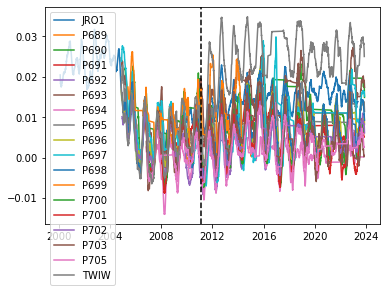

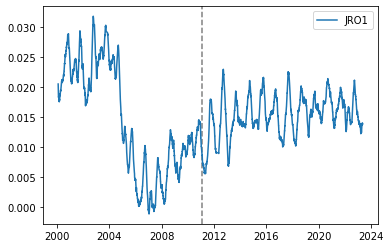

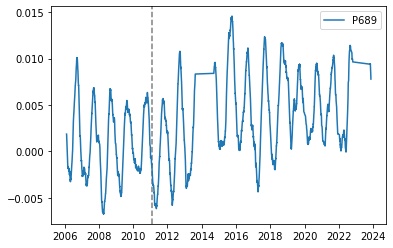

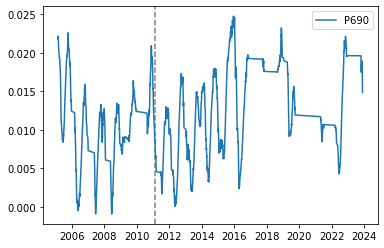

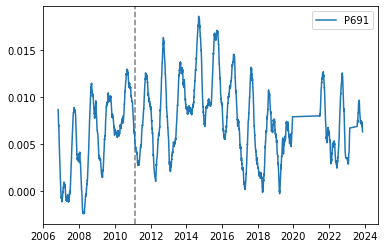

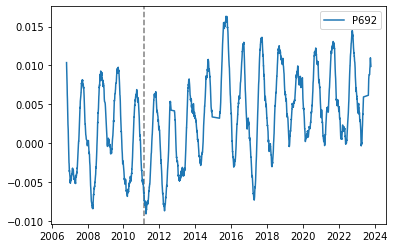

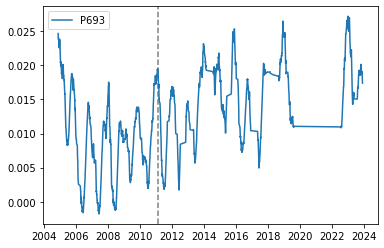

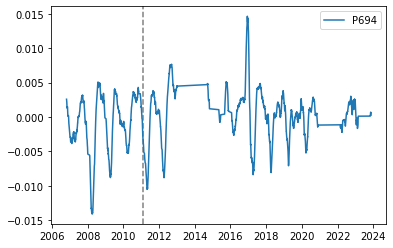

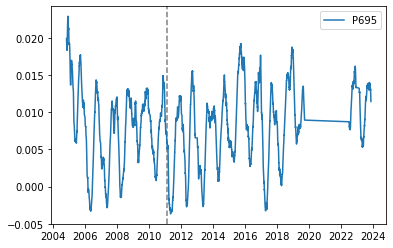

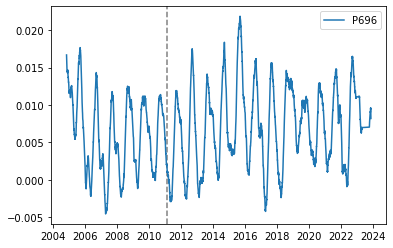

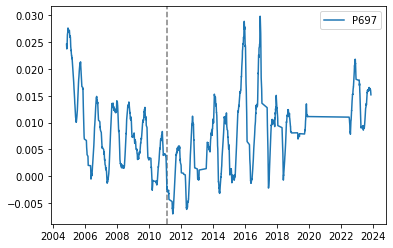

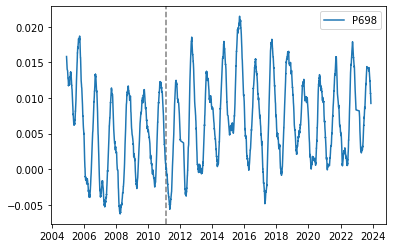

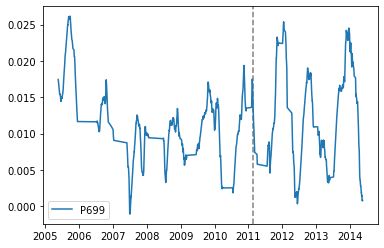

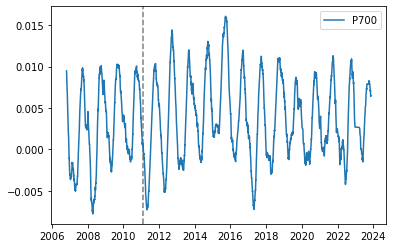

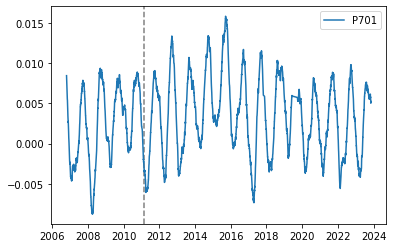

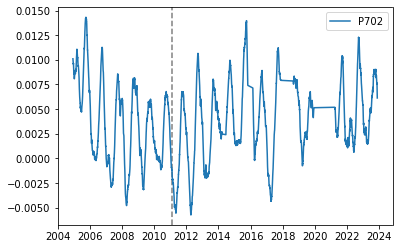

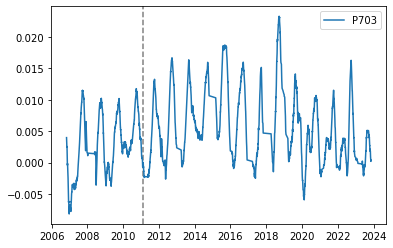

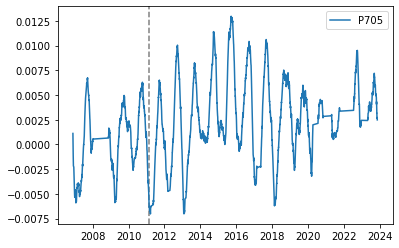

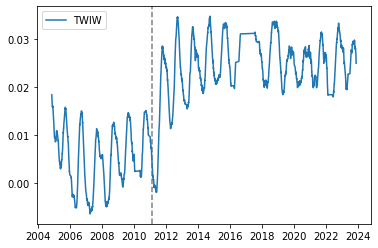

In [3]:
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    plt.plot(df['datetime'], positions[station]['offset'], label=station)
# make a vertical line on 2011-02-15
plt.axvline(datetime.datetime(2011, 2, 15), color='k', linestyle='--')
plt.legend()
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    plt.figure()
    plt.axvline(datetime.datetime(2011, 2, 15), color='k', linestyle='--', alpha=0.5)
    plt.plot(df['datetime'], positions[station]['offset'], label=station)
# make a vertical line on 2011-02-15
    
    plt.legend()
# plt.ylim(-0.1, 0.1)

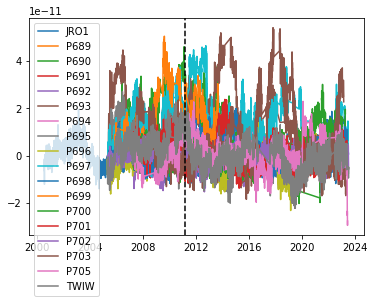

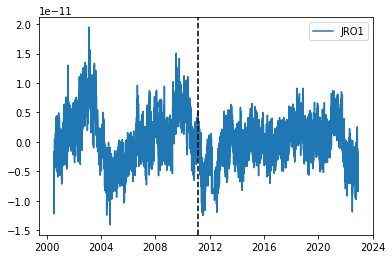

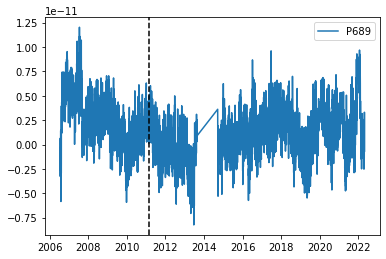

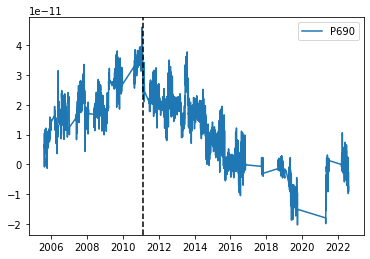

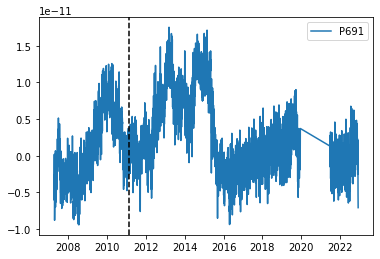

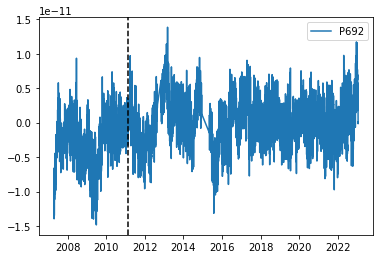

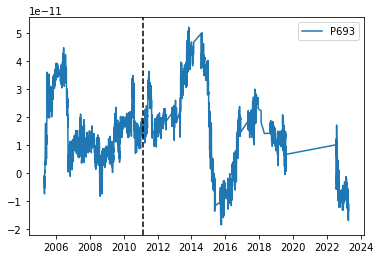

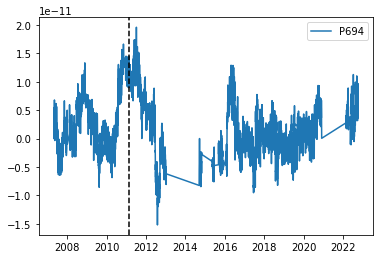

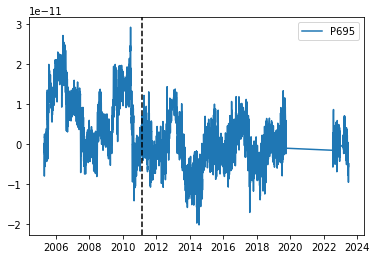

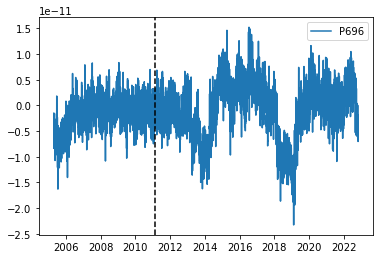

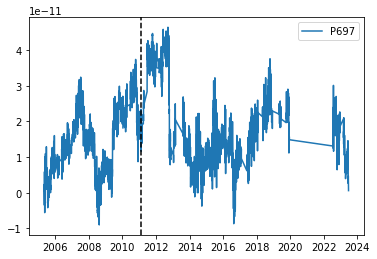

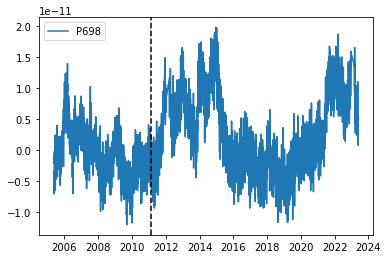

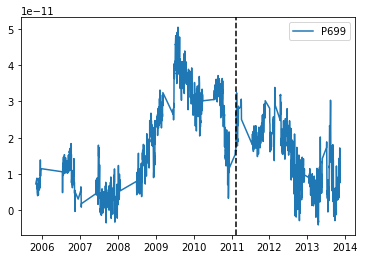

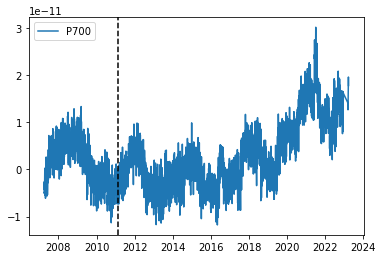

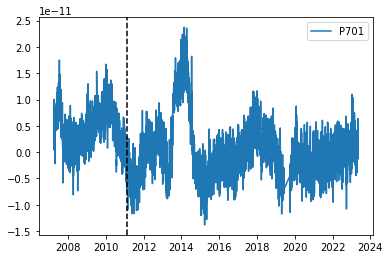

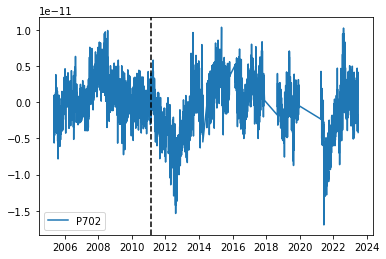

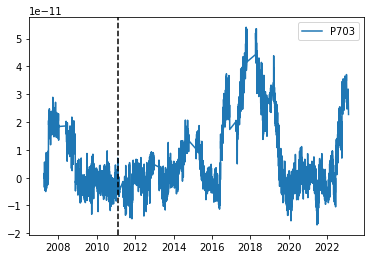

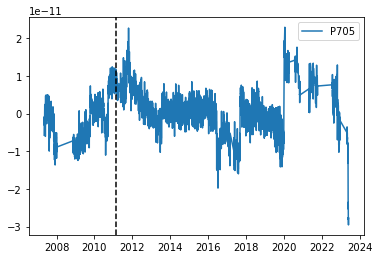

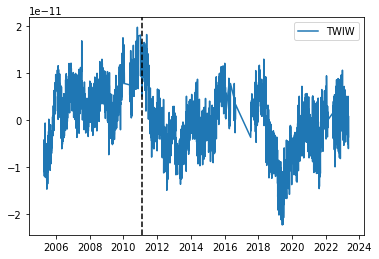

In [4]:
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    plt.plot(df['datetime'], positions[station]['velocity'], label=station)
# make a vertical line on 2011-02-15
plt.axvline(datetime.datetime(2011, 2, 15), color='k', linestyle='--')
plt.legend()
# plt.ylim(-0.1, 0.1)
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    plt.figure()
    # if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
    #     continue
    plt.plot(df['datetime'], positions[station]['velocity'], label=station)
    # make a vertical line on 2011-02-15
    plt.axvline(datetime.datetime(2011, 2, 15), color='k', linestyle='--')
    plt.legend()
# plt.ylim(-0.1, 0.1)


In [5]:
# load dv time-series
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime


corr_len = 2
std_model = 0.004
dv = {}
for freq0 in [0.25, 0.5, 1.0]:
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/linearised/new_gap_handling_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}*/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
    t = t[start:]
    dv[freq0] = -100*dvdt[:, :, start:]
datetimes = [UTCDateTime(tt).datetime for tt in t]



In [6]:
from obspy.signal.filter import highpass
from scipy.signal import detrend
# Filter dv signals
dv_hpf = {}
for freq0 in [0.25, 0.5, 1.0]:
    dv_1d = detrend(dv[freq0])
    df = 1/(datetimes[1]-datetimes[0]).total_seconds()
    filtfreq = 1/(2*365.25*24*60*60)
    dv_hpf[freq0] = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)

## map plot of total movement

In [7]:
from obspy.geodetics import degrees2kilometers, locations2degrees
import numpy as np

# extents of the dv/v grid
lat = [46.05, 46.36]
lon = [-122.45, -122.03]
res = 1


for station, df in positions.items():
    # compute cartesian coordinates of each station
    df['x'] = -degrees2kilometers(locations2degrees(lat[0], 0, lat[0], df['lon'][0]))
    df['y'] = degrees2kilometers(locations2degrees(0, lon[0], df['lat'][0], lon[0]))
    print(df['x'][0], df['y'][0])
    if np.min(np.abs(df['x'][0] - x)) > res or np.min(np.abs(df['y'][0] - y)) > res:
        print(f'Skipping {station}')
        continue
    

-8321.786533346592 5145.5596858174185
-8328.494231749892 5136.043623995178
-8320.483979059965 5134.980600496456
-8322.22546443249 5140.706027269384
-8320.218151500818 5139.929886681405
-8321.070045703977 5138.353142621587
-8320.111063501306 5148.283961520211
-8319.27867503598 5137.093304102703
-8318.687619400975 5136.858682807482
-8319.861179175015 5135.831241685287
-8319.109543372488 5134.255609574734
-8321.111367330659 5136.069198828306
-8321.774796489173 5134.774889882164
-8317.828584438676 5136.608494222532
-8327.792668724811 5148.342894831332
-8320.780781091671 5131.11880069409
-8326.14906001521 5134.198900162145
-8320.599509328662 5139.3405535701895
-8319.739988456871 5145.5730292086155
-8322.089331085306 5141.305367923998
-8319.021215919027 5138.642249430861
-8321.519862538056 5136.972101632659


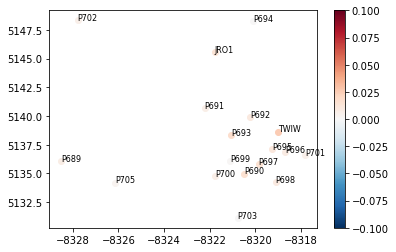

In [8]:
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    if np.isnan(df['offset'].values[-1]):
        continue
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['offset'].values[-1], vmin=-0.1, vmax=0.1, cmap='RdBu_r')
    # plot the name of the station right next to the dot
    plt.text(df['x'].values[0], df['y'].values[0], station, fontsize=8)
plt.colorbar()

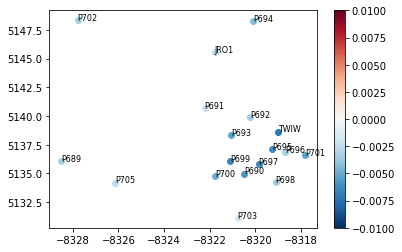

In [9]:
# plot change between 2011-02-01 and 2011-03-01 in the same style as above
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    if np.isnan(df['offset'].values[-1]):
        continue
    ii = np.argmin(abs(df['datetime'] - datetime.datetime(2011, 2, 1)))
    jj = np.argmin(abs(df['datetime'] - datetime.datetime(2011, 3, 30)))
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['offset'].values[jj]-df['offset'].values[ii], vmin=-0.01, vmax=0.01, cmap='RdBu_r')
    # plot the name of the station right next to the dot
    plt.text(df['x'].values[0], df['y'].values[0], station, fontsize=8)
plt.colorbar()

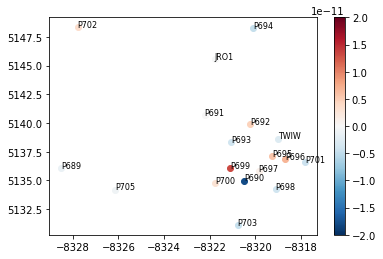

In [10]:
# plot change between 2011-02-01 and 2011-03-01 in the same style as above
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    if np.isnan(df['offset'].values[-1]):
        continue
    ii = np.argmin(abs(df['datetime'] - datetime.datetime(2011, 2, 1)))
    jj = np.argmin(abs(df['datetime'] - datetime.datetime(2011, 3, 30)))
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['velocity'].values[jj]-df['velocity'].values[ii], vmin=-2e-11, vmax=2e-11, cmap='RdBu_r')
    # plot the name of the station right next to the dot
    plt.text(df['x'].values[0], df['y'].values[0], station, fontsize=8)
plt.colorbar()

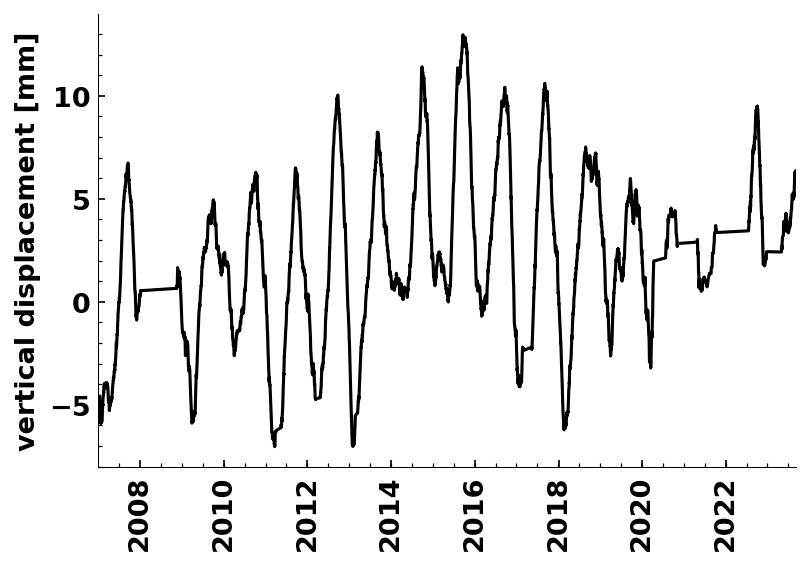

In [11]:
from seismic.plot.plot_utils import set_mpl_params
import datetime
set_mpl_params()
# plot station P705
station = 'P705'
plt.figure()
plt.plot(positions[station]['datetime'], positions[station]['offset']*1e3, 'k', label=station)
plt.ylabel('vertical displacement [mm]')
# x-axis ticklabel rotation
plt.xticks(rotation=90)
plt.xlim(datetime.datetime(2007, 1, 1), datetime.datetime(2023, 9, 1))
# station = 'P691'
# plt.plot(positions[station]['date'], positions[station]['dU']*1e3, 'k', label=station)
# plt.ylabel('vertical displacement [mm]')
# # x-axis ticklabel rotation
# plt.xticks(rotation=90)
# turn top and right axes off
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# turn off ticks where there is no spine
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')


plt.savefig('/home/pm/Documents_sync/PhD/conferences/AGU23/poster/P705.png', dpi=300, transparent=True, bbox_inches='tight')

## 1D comparison dv/v and GPS motion

/tmp/ipykernel_11941/3985598591.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


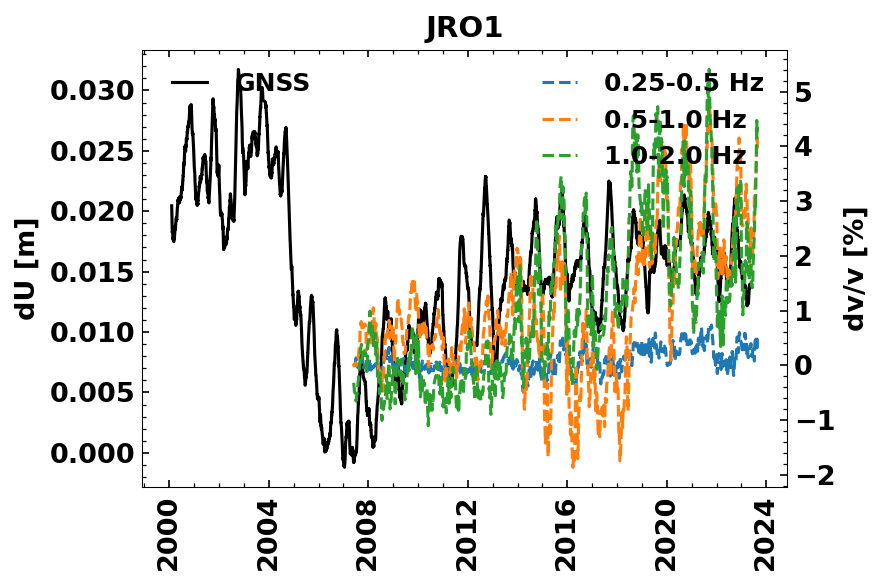

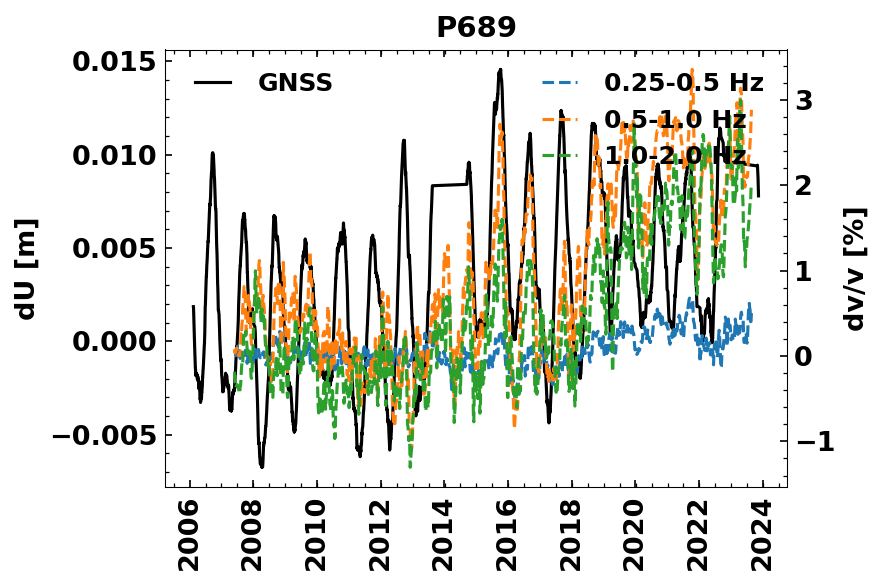

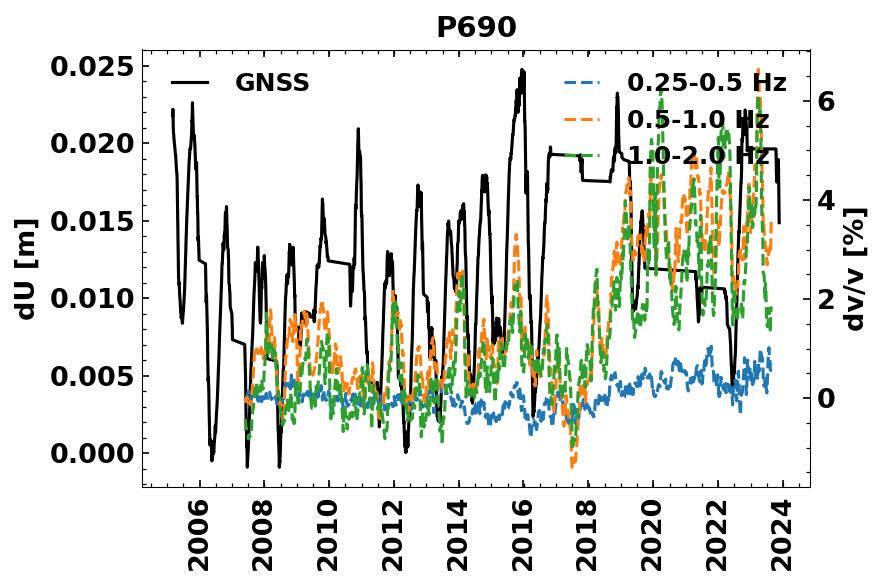

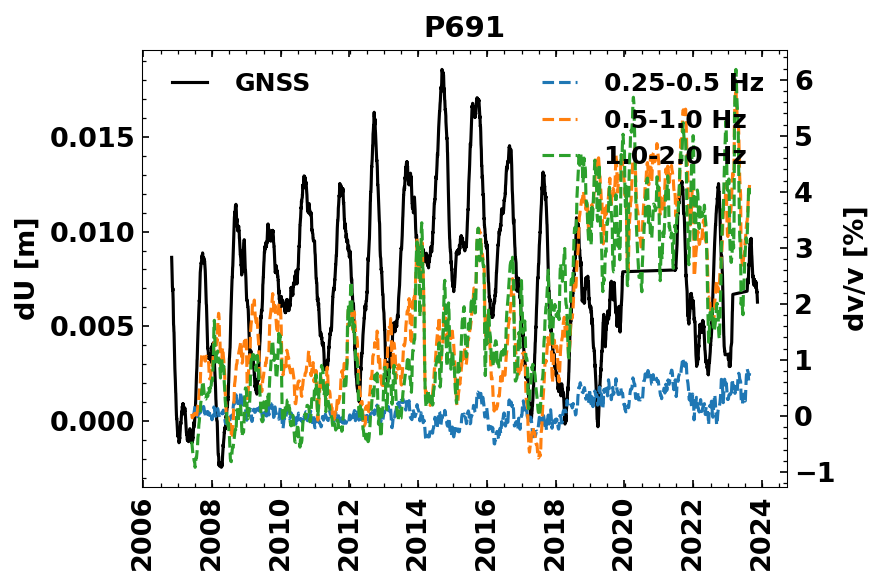

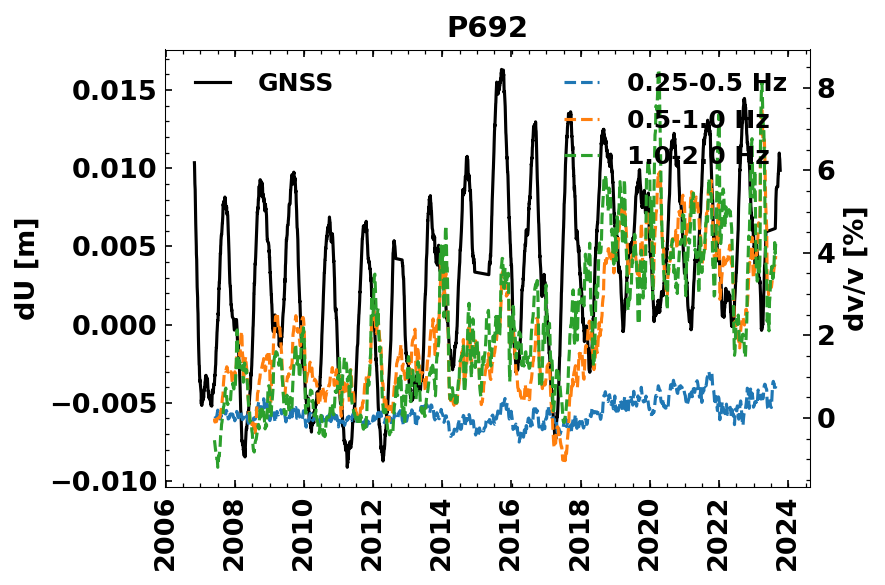

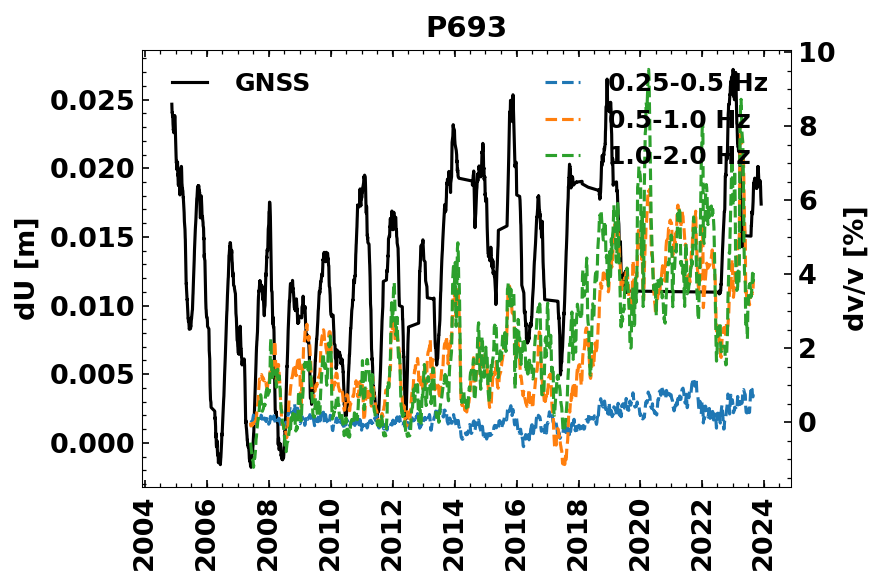

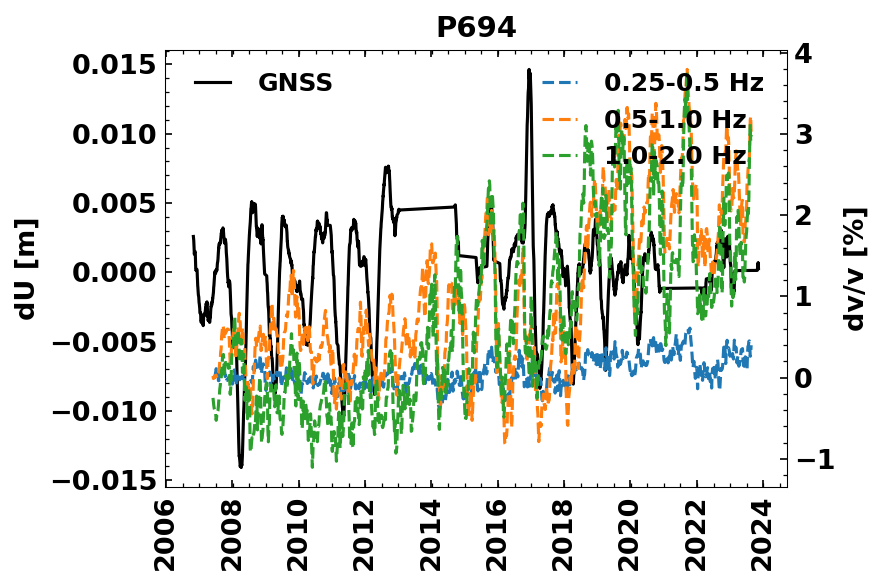

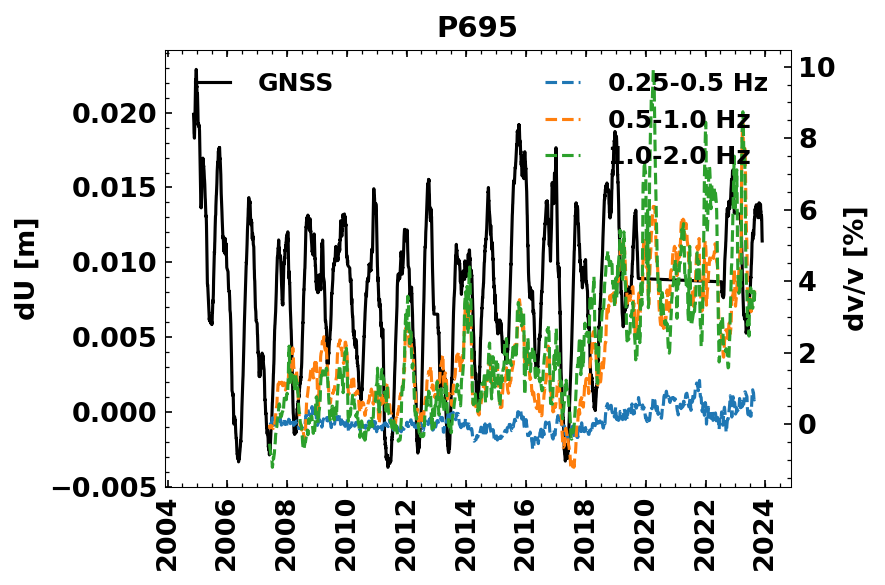

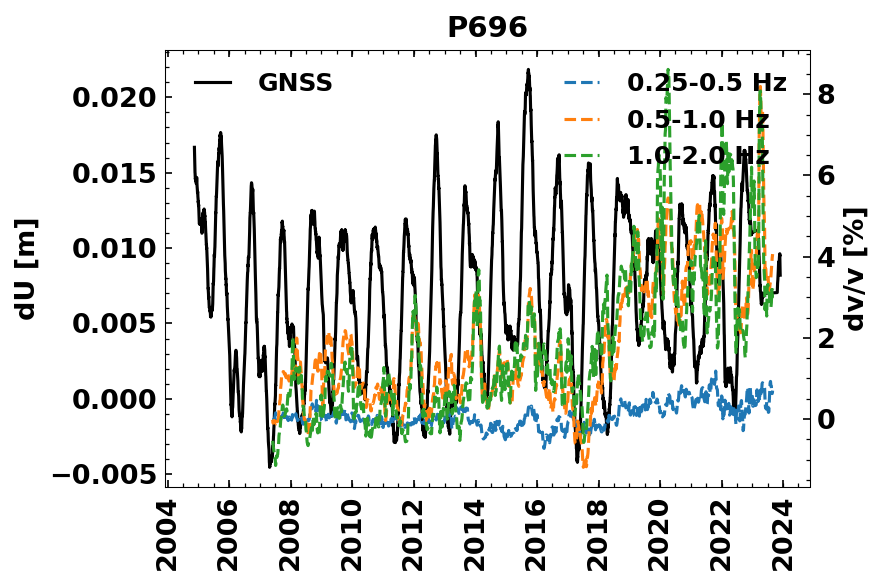

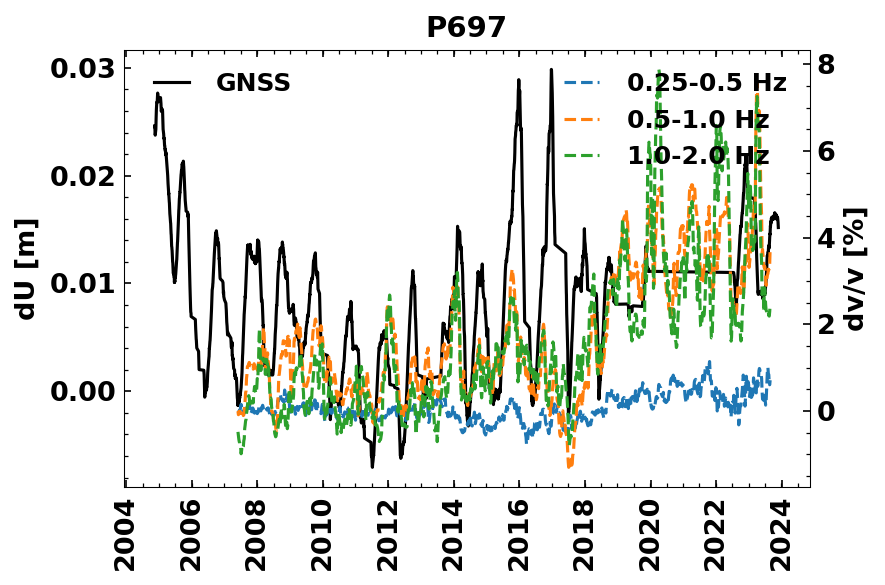

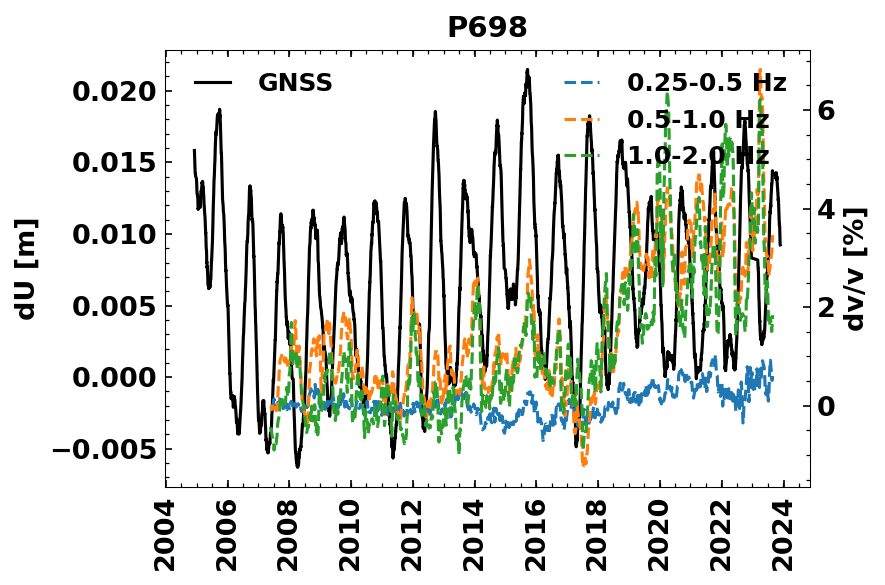

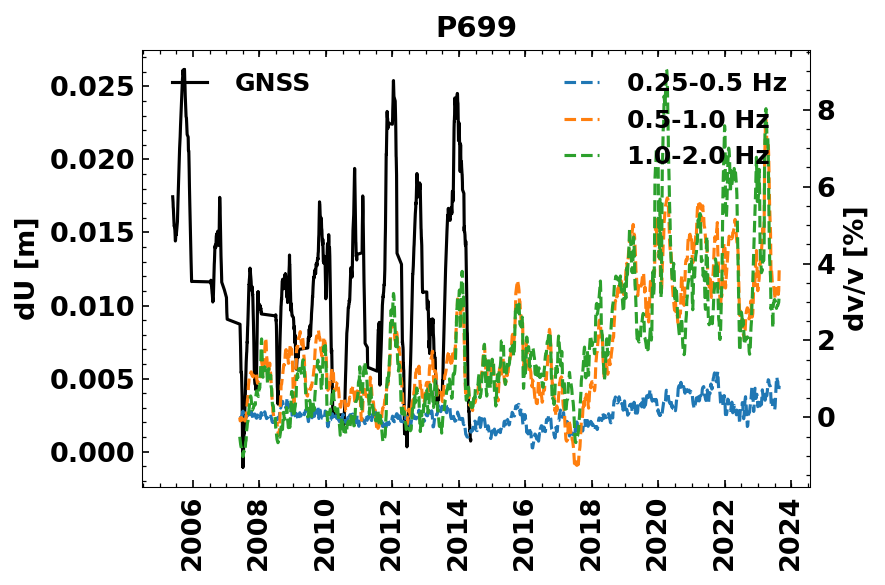

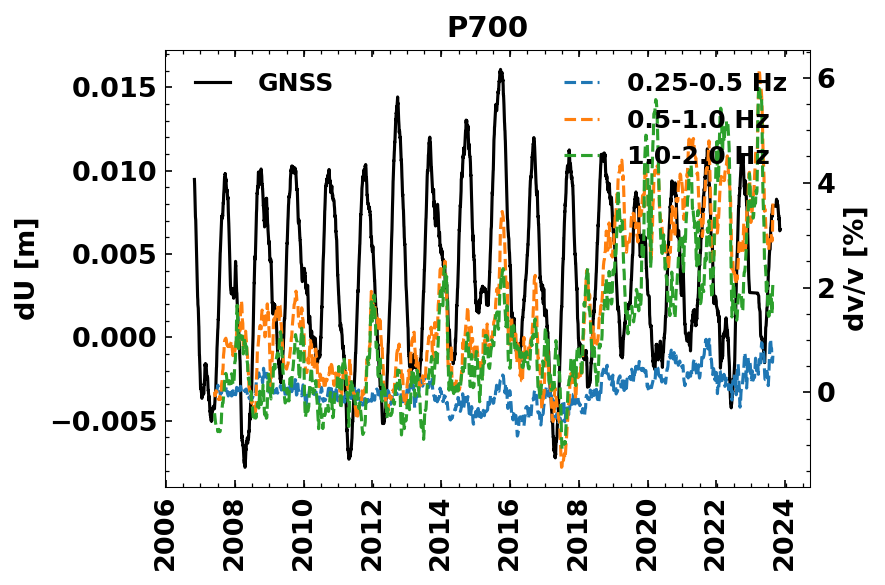

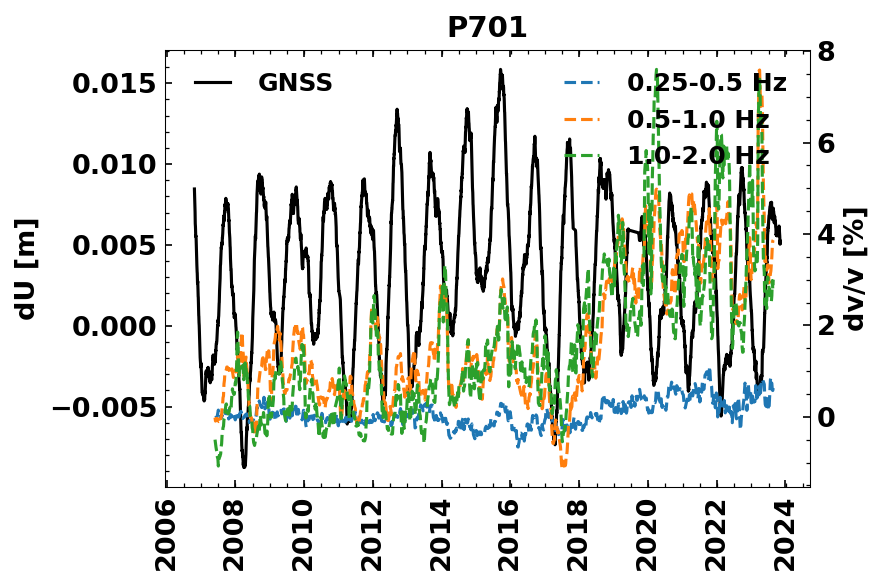

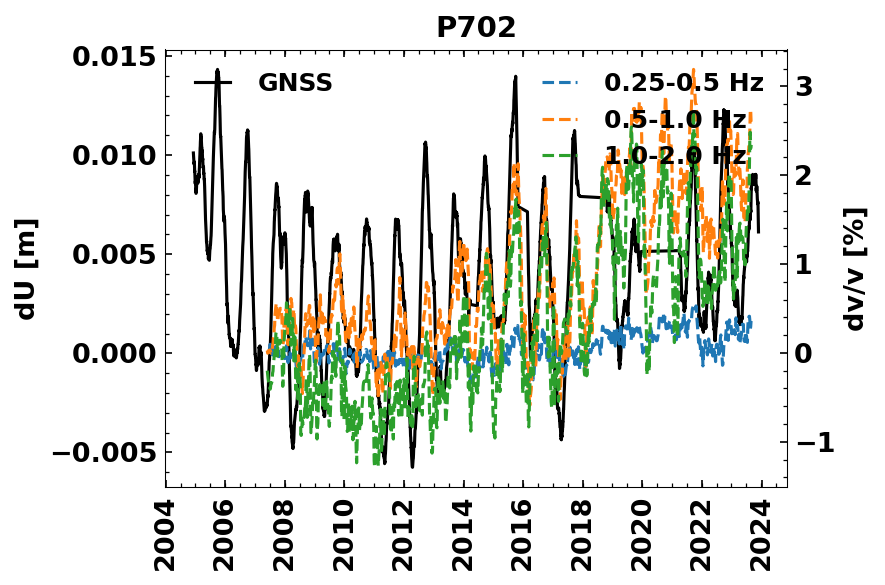

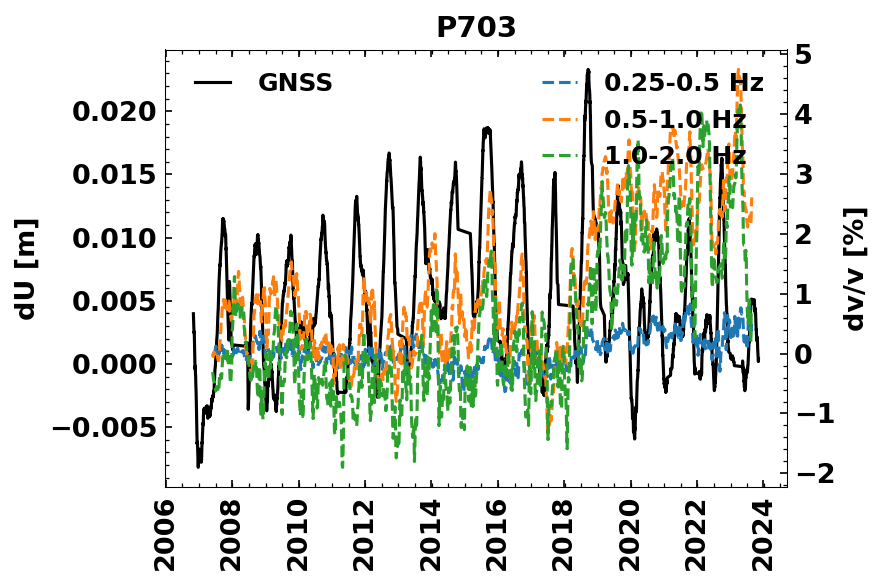

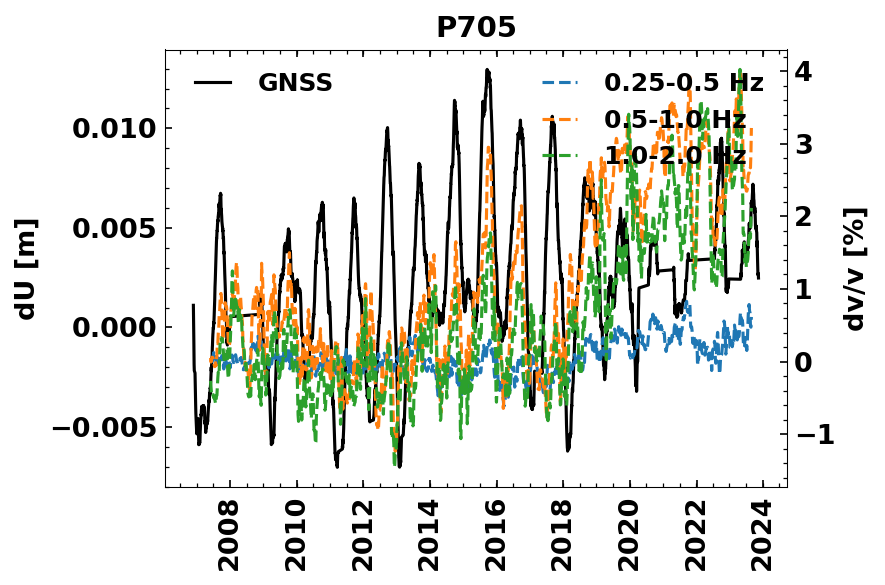

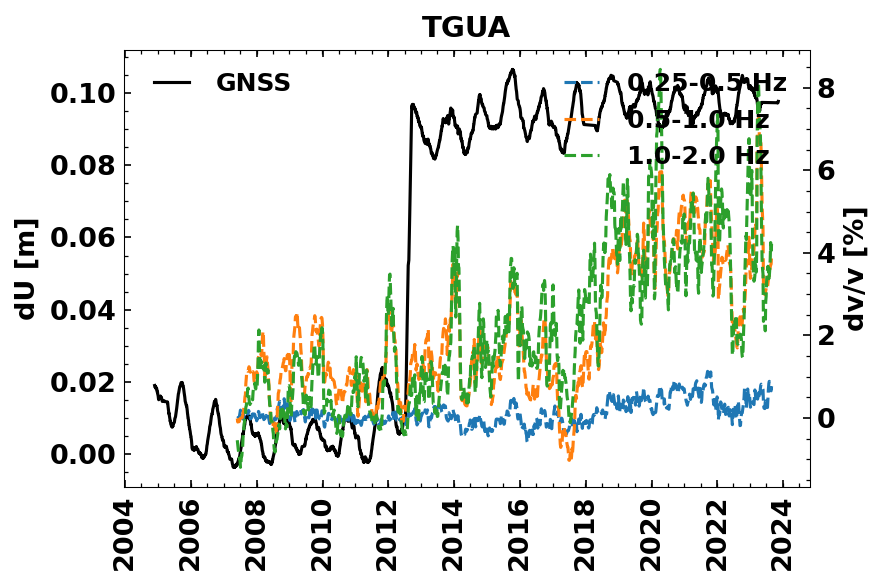

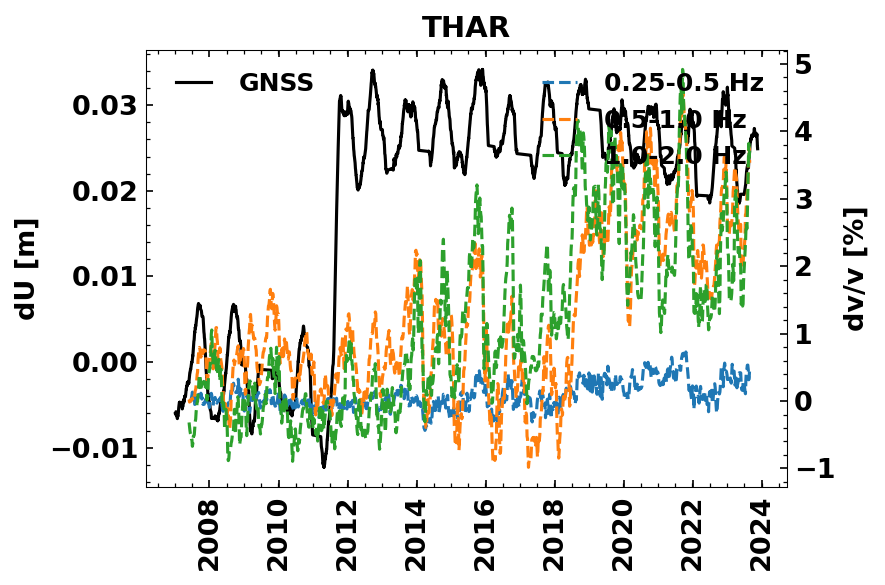

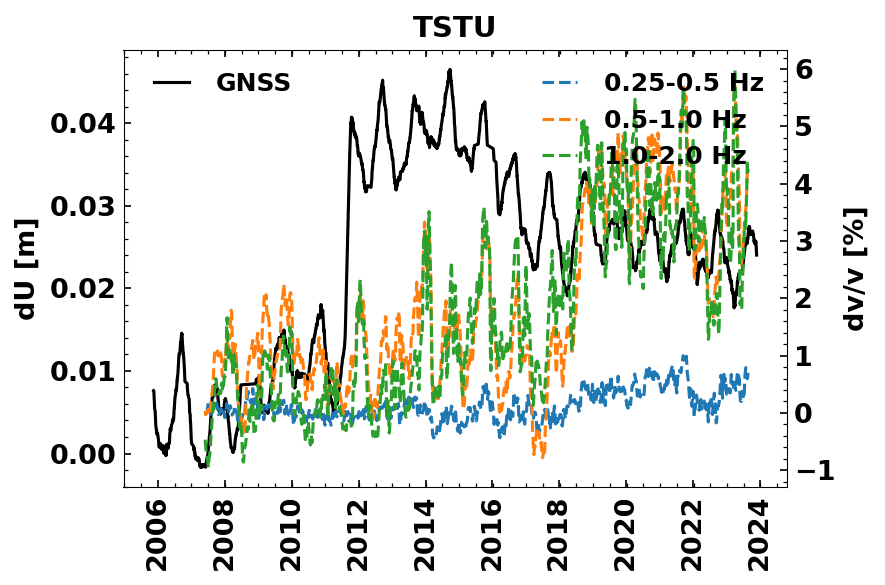

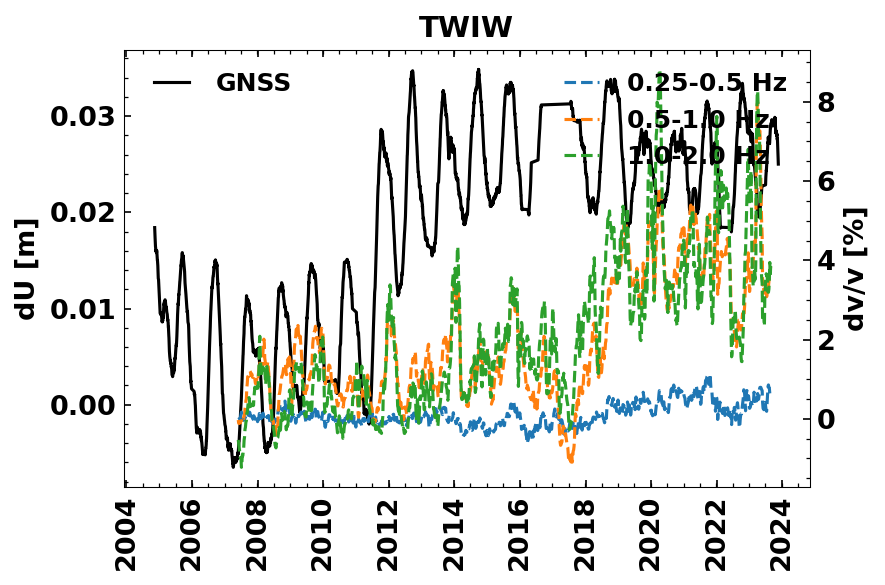

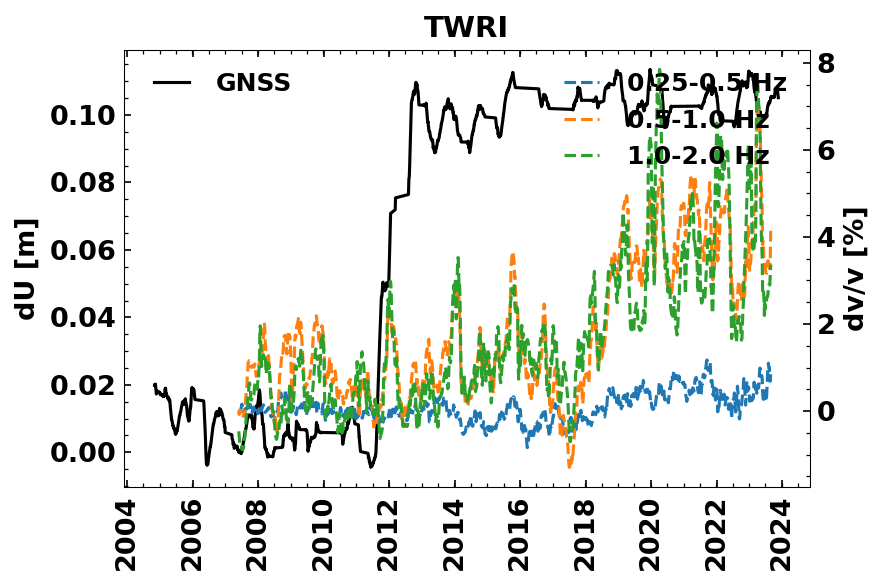

In [12]:
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# find closest grid point of each station and plot against dv/v of this grid point

for station, df in positions.items():
    plt.figure()
    # find closest grid point
    plt.plot(df['datetime'], df['offset'], label='GNSS', color='k')
    plt.ylabel('dU [m]')
    plt.legend()
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    plt.twinx()
    xind = np.argmin(np.abs(df['x'][0] - x))
    yind = np.argmin(np.abs(df['y'][0] - y))
    # plot dv/v time series
    for freq0 in [0.25, 0.5, 1.0]:
        plt.plot(datetimes, dv[freq0][yind, xind, :], label=f'{freq0}-{freq0*2} Hz', linestyle='--')
    # plot this legend in top right
    plt.legend(loc='upper right')
    plt.ylabel('dv/v [%]')
    plt.title(station)
    
    plt.tight_layout()


# UW long time series vs JRO1 GPS

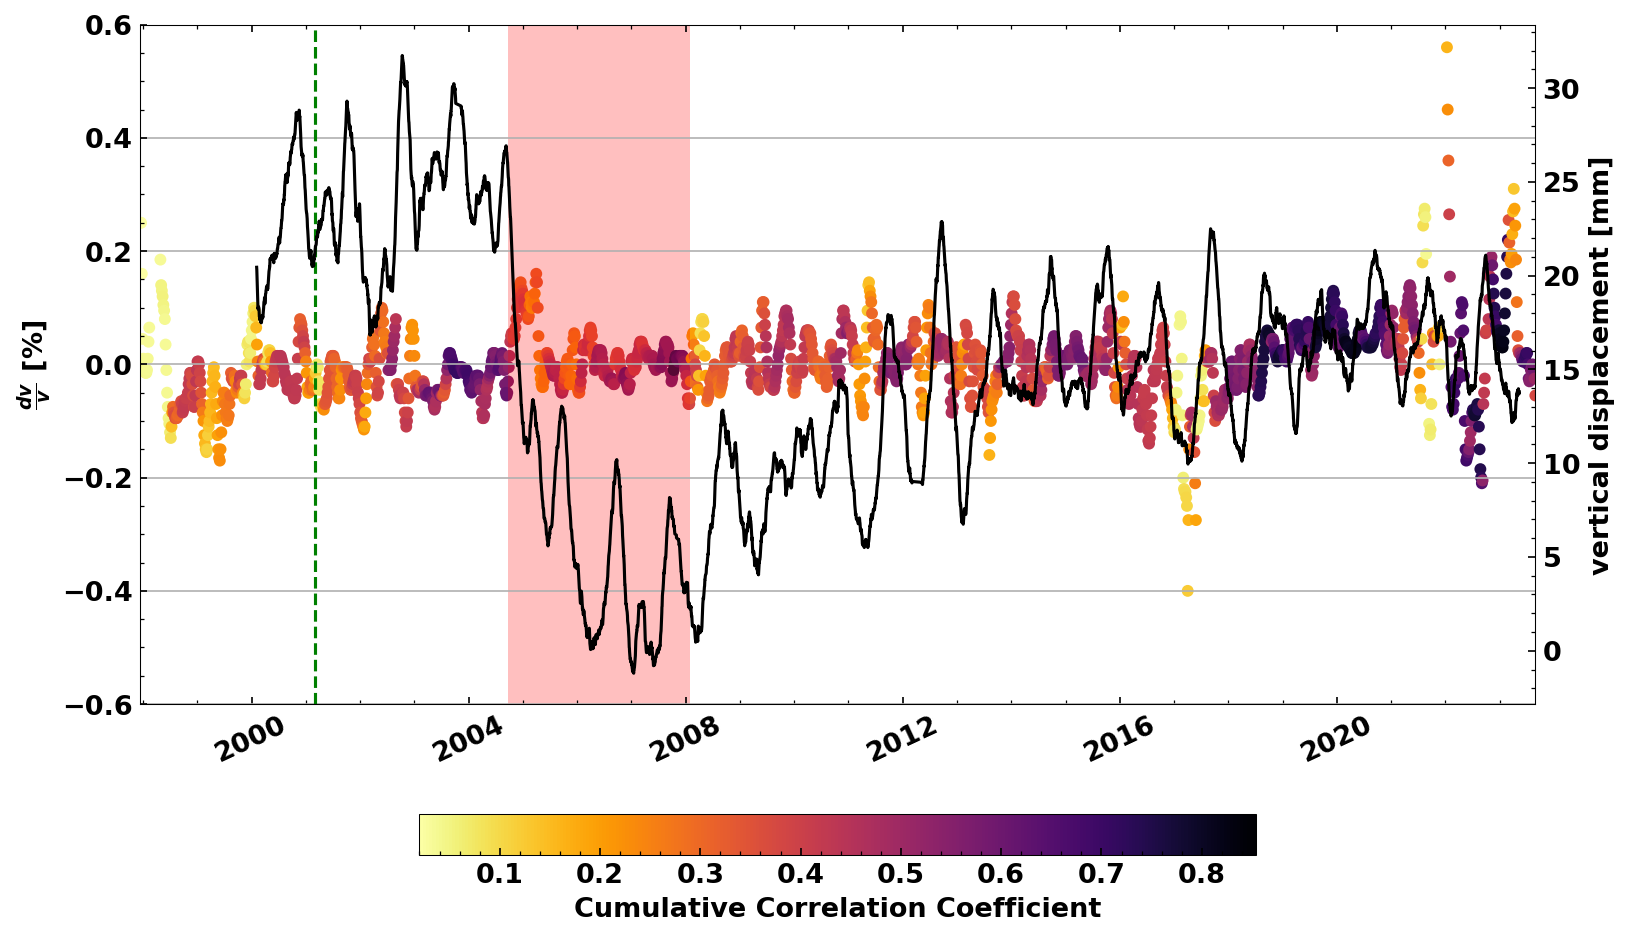

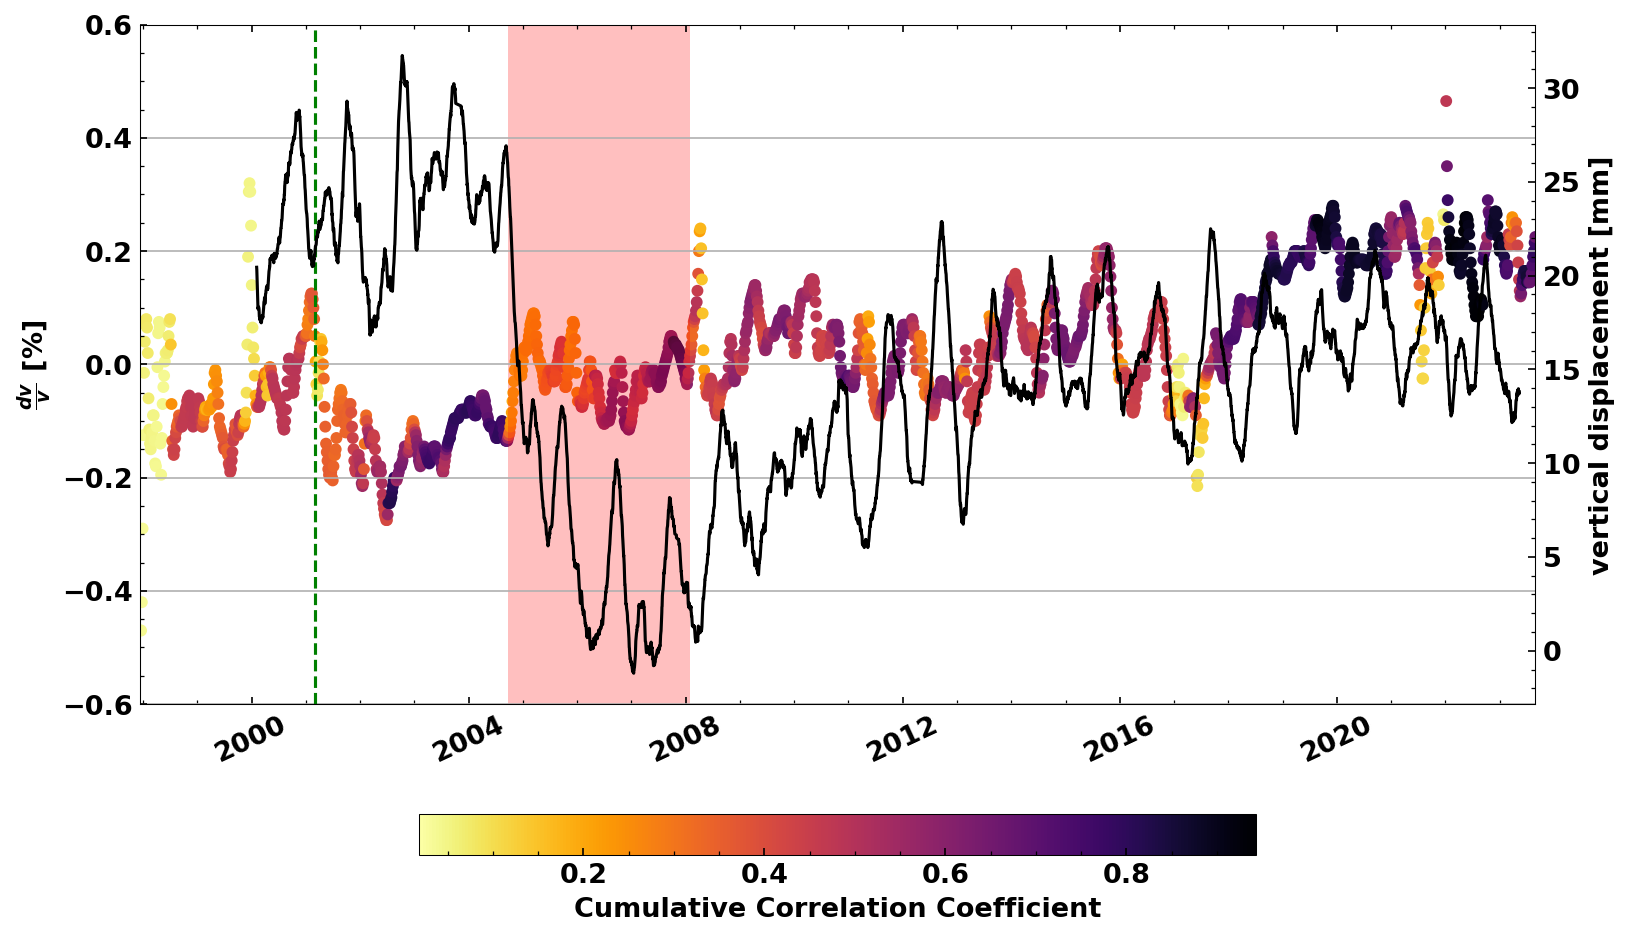

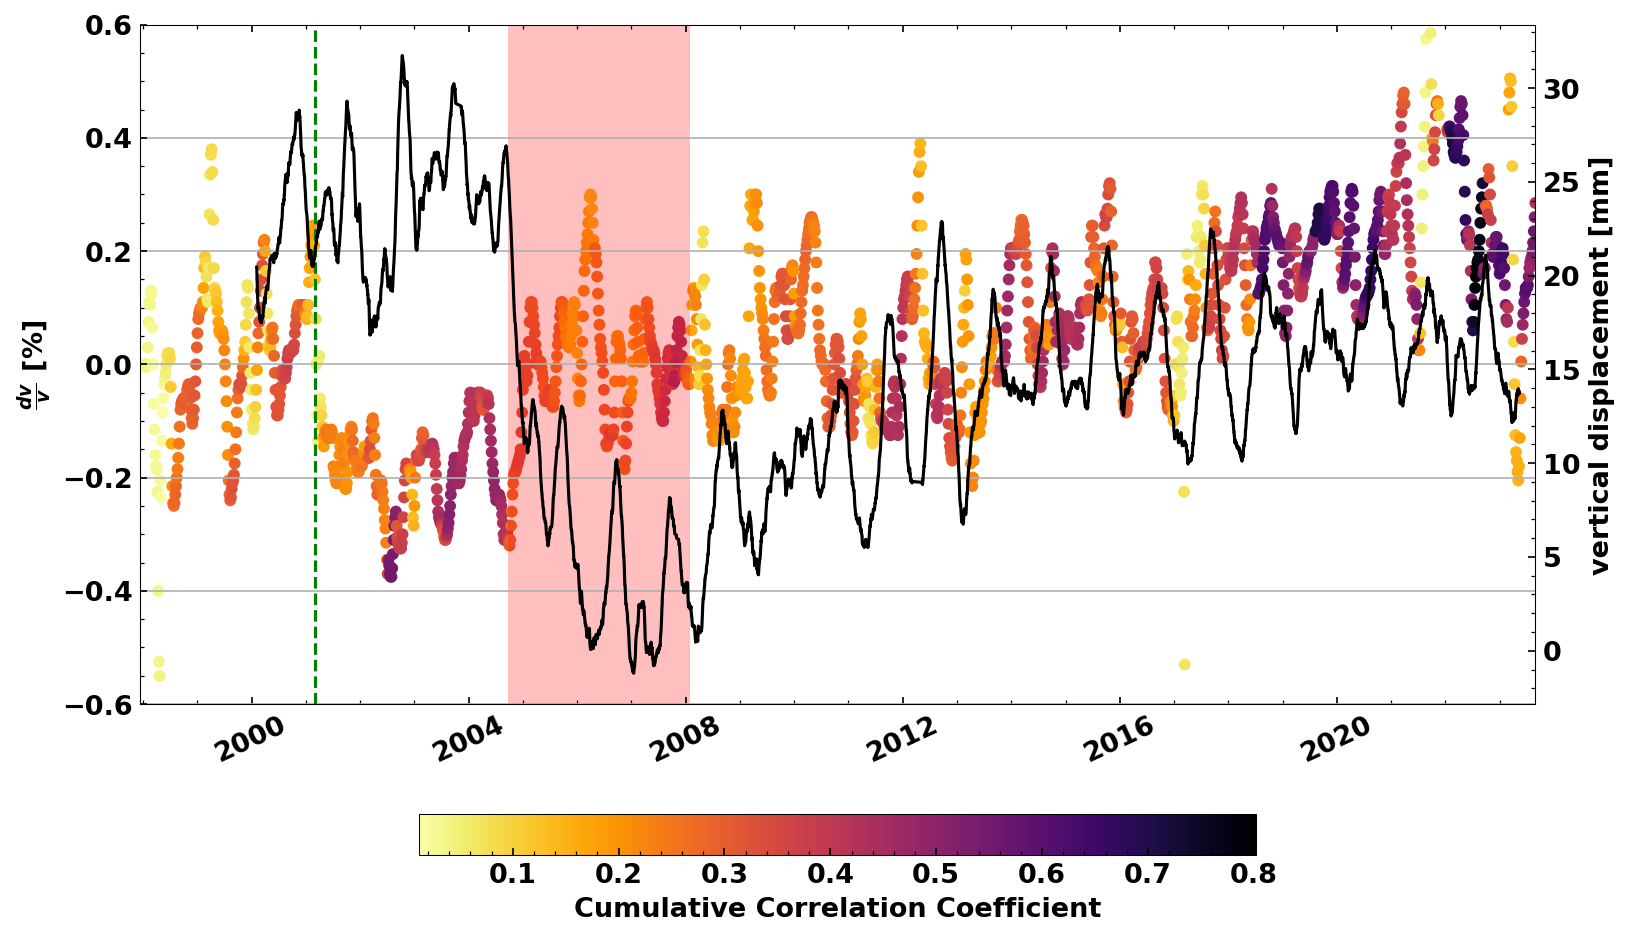

In [13]:
import os
import glob

from seismic.monitor.dv import read_dv
from seismic.plot.plot_utils import set_mpl_params

from matplotlib import pyplot as plt
from obspy import UTCDateTime

set_mpl_params()
infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/dv/with_sim_mat/UW_average_*.npz')
# plot dv/v time series
for infile in infiles:
    dv_av = read_dv(infile)

    outfile = os.path.join(
        '/home/pm/Documents_sync/PhD/StHelens/paper/figures/',
        os.path.basename(infile)[:-4] + '.png')
    ax = dv_av.plot(
        dateformat='%Y', style='publication', ylim=(-.6, .6),
        title=None, return_ax=True)
    # origin time of the Nisqually earthquake
    neq = UTCDateTime('2001-02-28 18:54:32').datetime
    plt.vlines(neq, -.6, .6, colors=['g'], linestyles='dashed')
    # plt.vlines(UTCDateTime('2011-02-14 18:32:25').datetime, -.6, .6, colors=['g'], linestyles='dashed')
    # plt.vlines(UTCDateTime('2018-01-03 08:36:25').datetime, -.6, .6, colors=['g'], linestyles='dashed')
    plt.axvspan(UTCDateTime(2004, 9, 23).datetime, UTCDateTime(2008, 1, 31).datetime, facecolor='r', alpha=0.25)
    ax2 = plt.twinx()
    # ax2.plot(positions['JRO1']['datetime'], positions['JRO1']['offset']*1e3, 'k', zorder=0)
    ax2.plot(positions['JRO1']['datetime'], positions['JRO1']['offset']*1e3, 'k', zorder=0)
    ax2.set_ylabel('vertical displacement [mm]')
    plt.savefig(outfile, dpi=300, facecolor='None')
    # plt.close()

## Plotting GPS against dv/v - comparison of seasonal signals

/tmp/ipykernel_11941/2889074820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_11941/2889074820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_11941/2889074820.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_11941/2889074820.py:11: SettingWithCopyWarning: 
A value is tryi

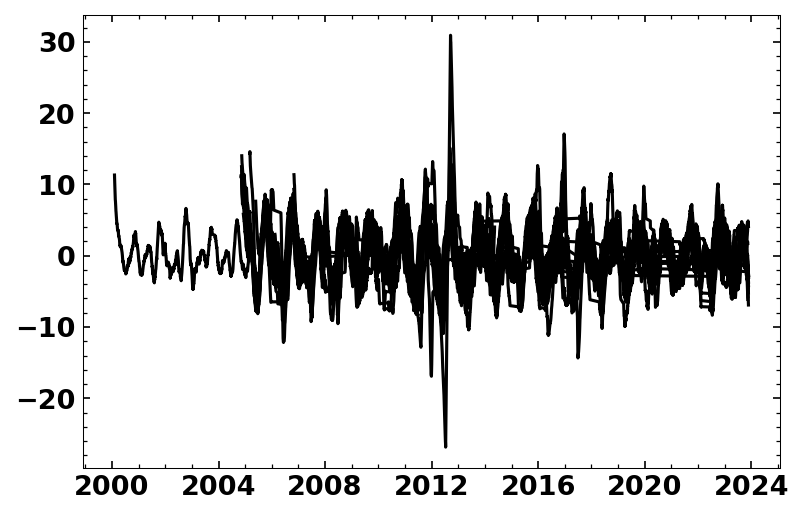

In [14]:
# highpass filter GPS time series
from obspy.signal.filter import highpass
from scipy.signal import detrend
for stat in positions.values():
    nani = np.isnan(stat['offset'])
    offset_1d = np.nan_to_num(stat['offset'], copy=True)
    df = 1/(stat['datetime'][1]-stat['datetime'][0]).total_seconds()
    filtfreq = 1/(365.25*24*60*60)
    # mask nans
    stat['offset_hpf'] = highpass(offset_1d, filtfreq, df, corners=4, zerophase=True)
    stat['offset_hpf'][nani] += np.nan
    plt.plot(stat['datetime'], stat['offset_hpf']*1e3, 'k', zorder=0)

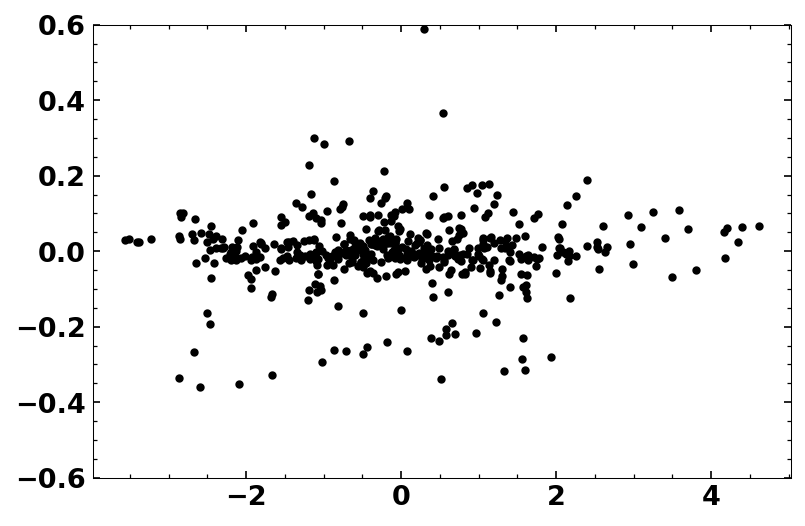

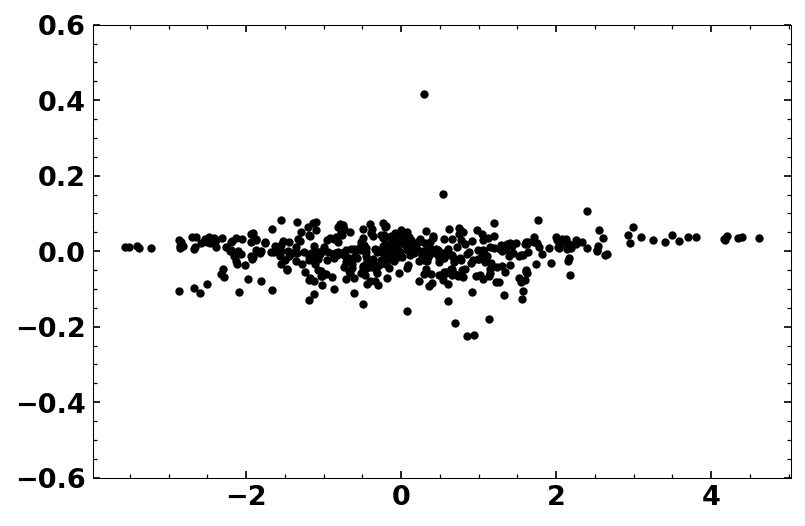

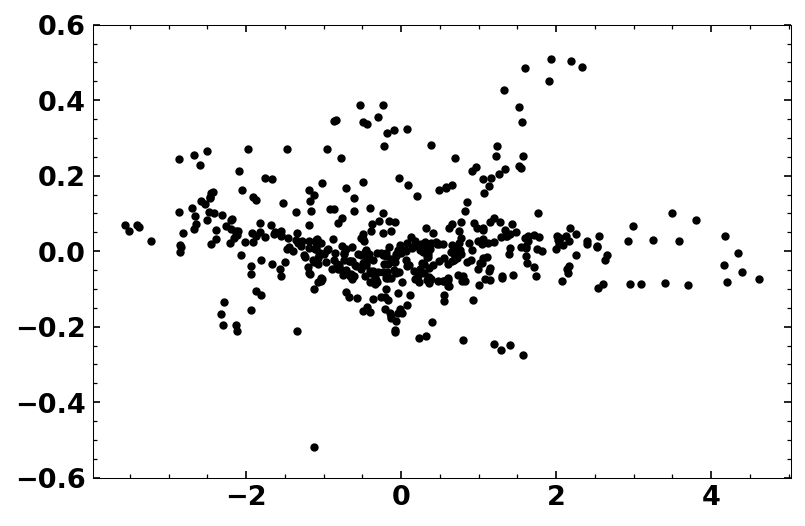

In [15]:
# plot dv/v against height change
import os
import glob

from seismic.monitor.dv import read_dv
from seismic.plot.plot_utils import set_mpl_params
import numpy as np

from matplotlib import pyplot as plt
from obspy import UTCDateTime

set_mpl_params()
infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/dv/with_sim_mat/UW_average_*.npz')
# plot dv/v time series
for infile in infiles:
    # if '0.25' in infile:
    #     continue
    dv_av = read_dv(infile)
    dv_1d = np.nan_to_num(-100*dv_av.value, copy=True)
    df = 1/(dv_av.stats.corr_start[1]-dv_av.stats.corr_start[0])
    filtfreq = 1/(365.25*24*60*60)
    # mask nans
    dv_1d_filt = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)
    dv_1d_filt[~dv_av.avail] = np.nan

    outfile = os.path.join(
        '/home/pm/Documents_sync/PhD/StHelens/paper/figures/',
        os.path.basename(infile)[:-4] + '.png')

    # interpolate GPS data to dv/v time series
    # find closest grid point
    gps_int = np.interp([_t.timestamp for _t in dv_av.stats.corr_start[-500:]], [UTCDateTime(_t).timestamp for _t in positions['JRO1']['datetime']], positions['JRO1']['offset_hpf'], left=np.nan, right=np.nan)
    # origin time of the Nisqually earthquake
    plt.figure()
    plt.plot(gps_int*1e3, dv_1d_filt[-500:], 'k.')
    plt.ylim(-.6, .6)
    # plt.savefig(outfile, dpi=300, facecolor='None')
    # plt.close()

In [16]:
dv_hpf = {}
for freq, value in dv.items():
    nani = np.isnan(value)
    dv_1d = np.nan_to_num(value, copy=True)
    df = 1/(datetimes[1]-datetimes[0]).total_seconds()
    filtfreq = 1/(365.25*24*60*60)
    # mask nans
    dv_hpf[freq] = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)
    dv_hpf[freq][nani] += np.nan

/tmp/ipykernel_11941/1669567009.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


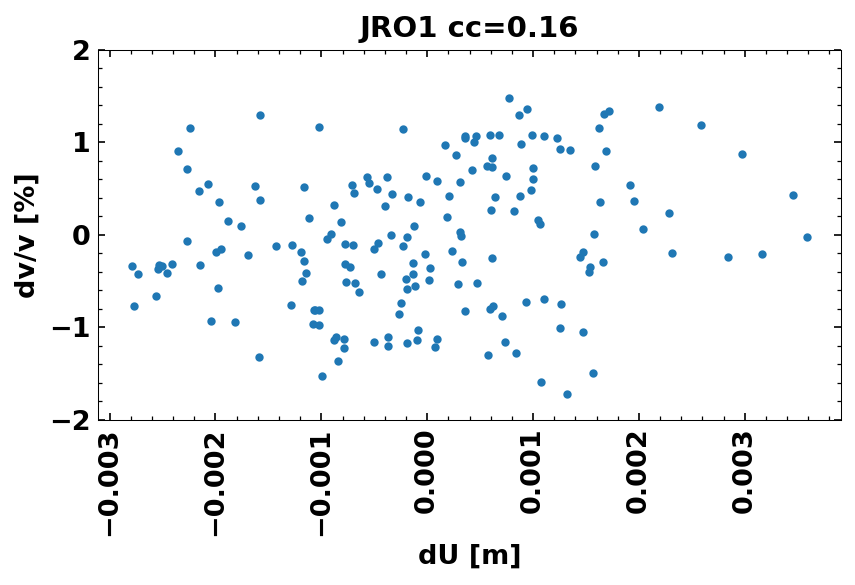

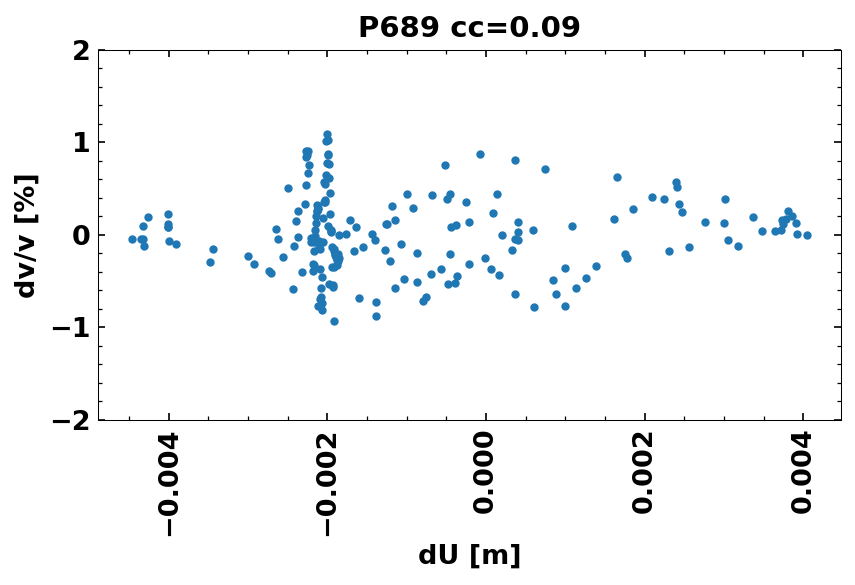

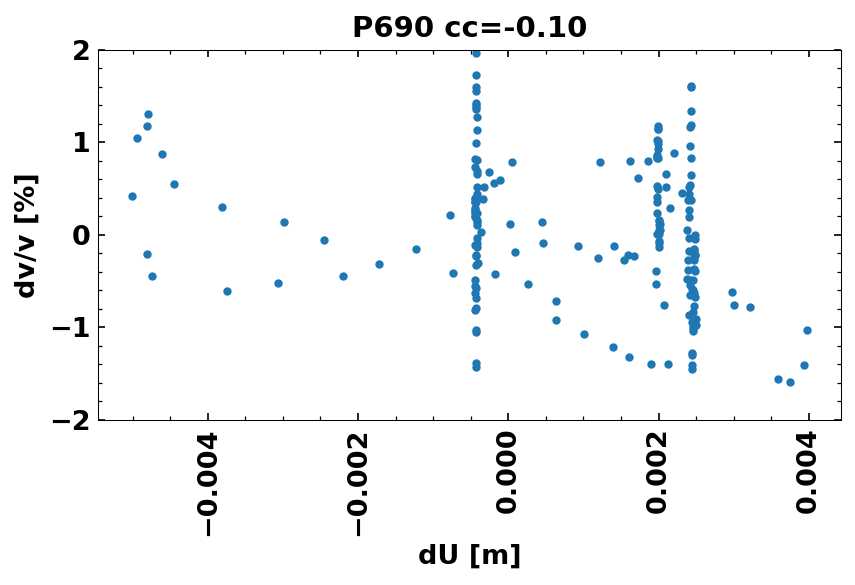

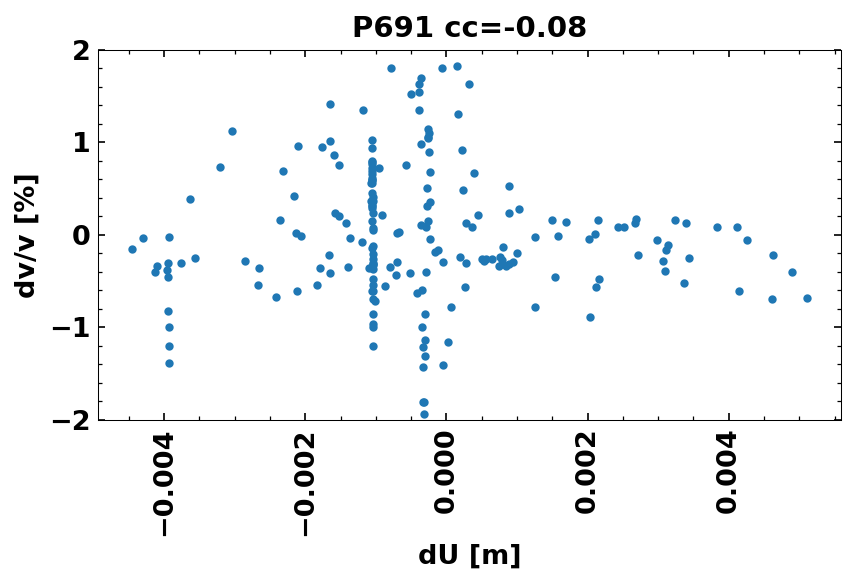

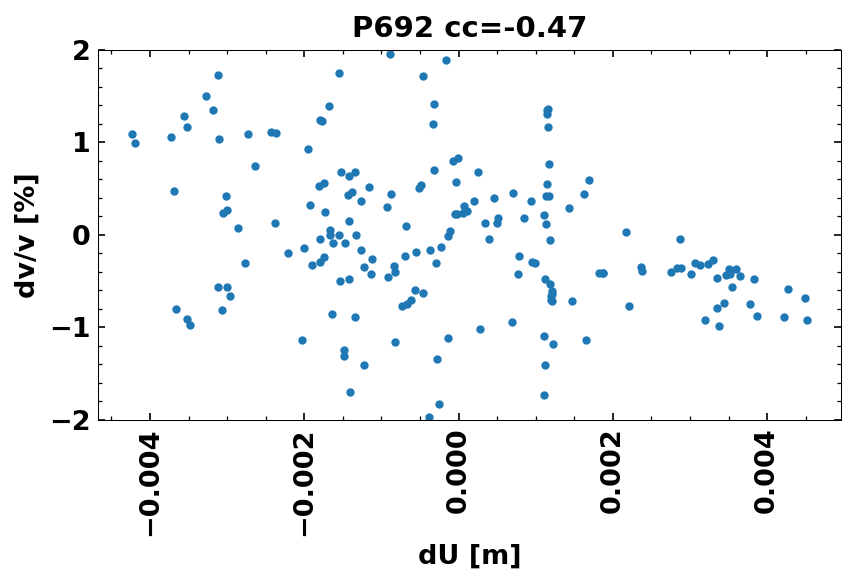

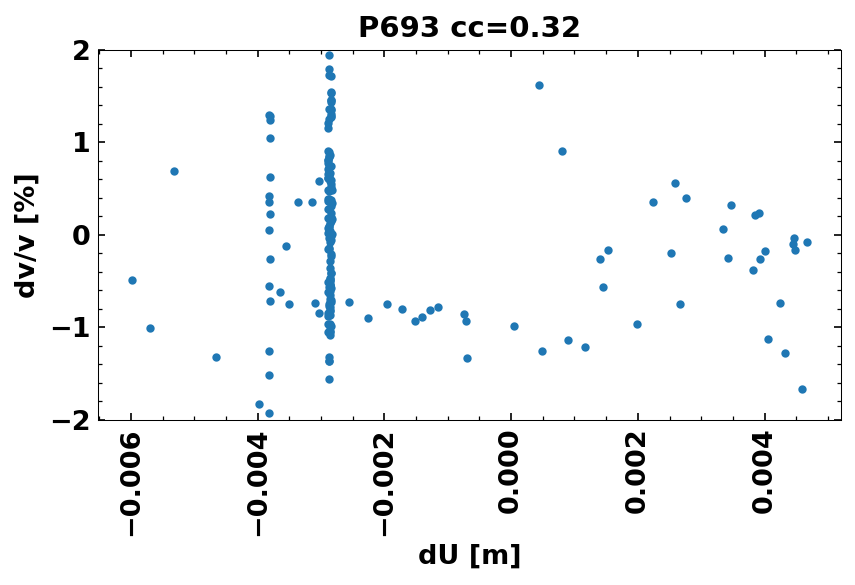

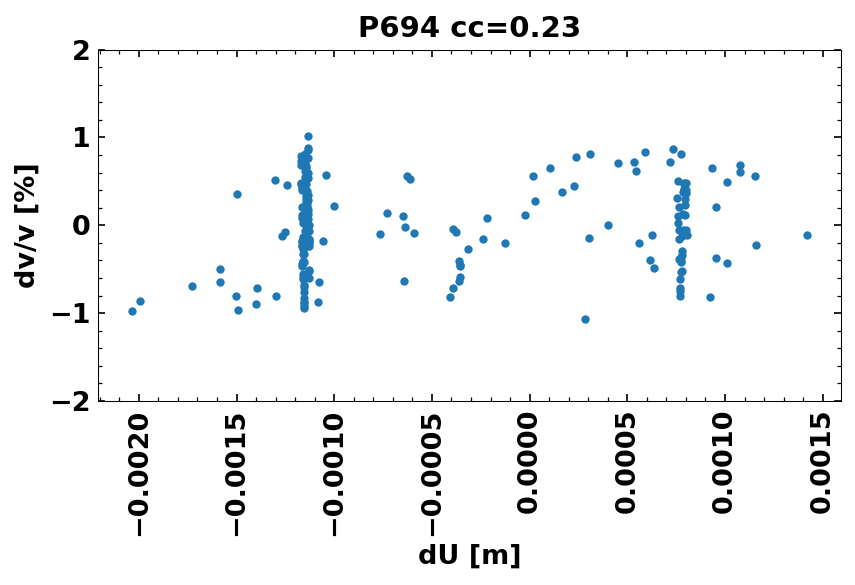

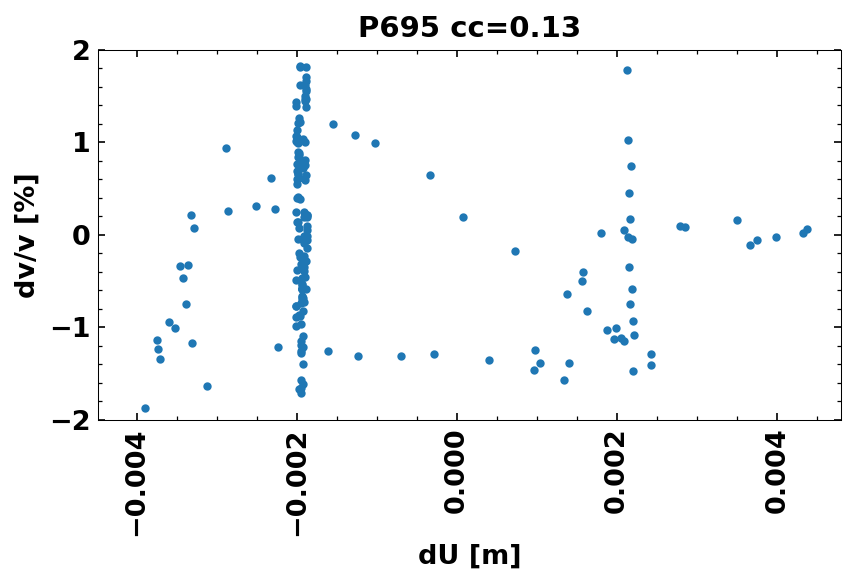

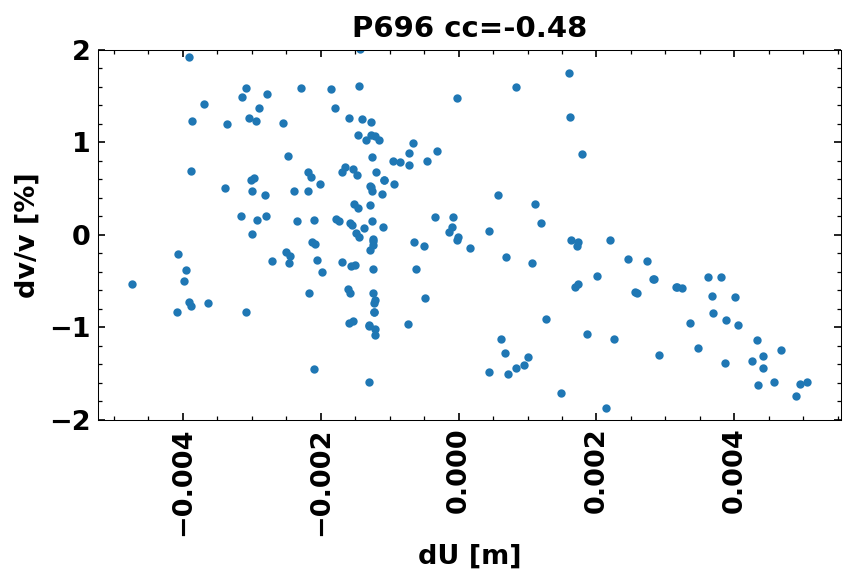

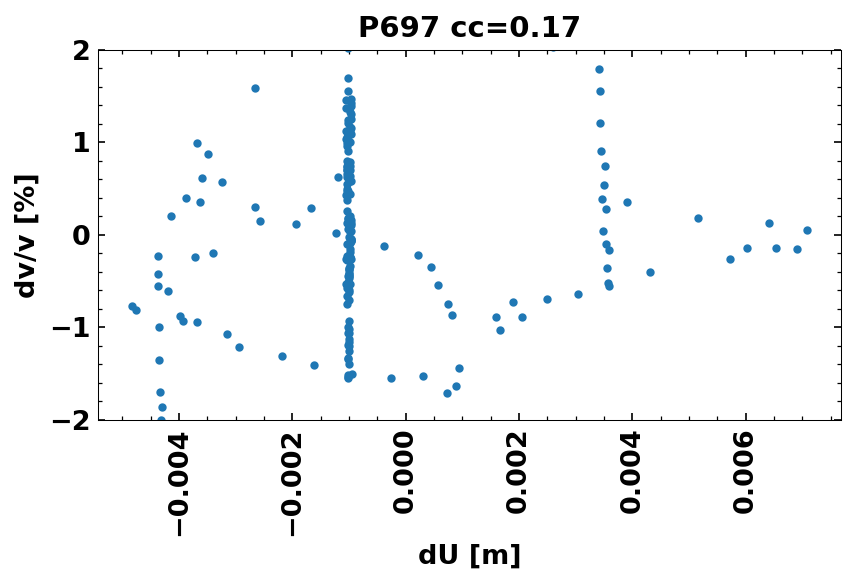

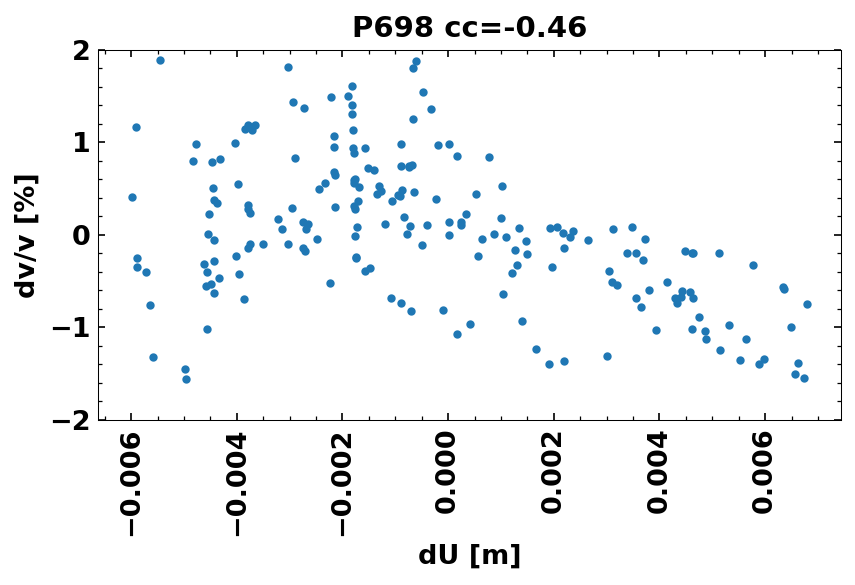

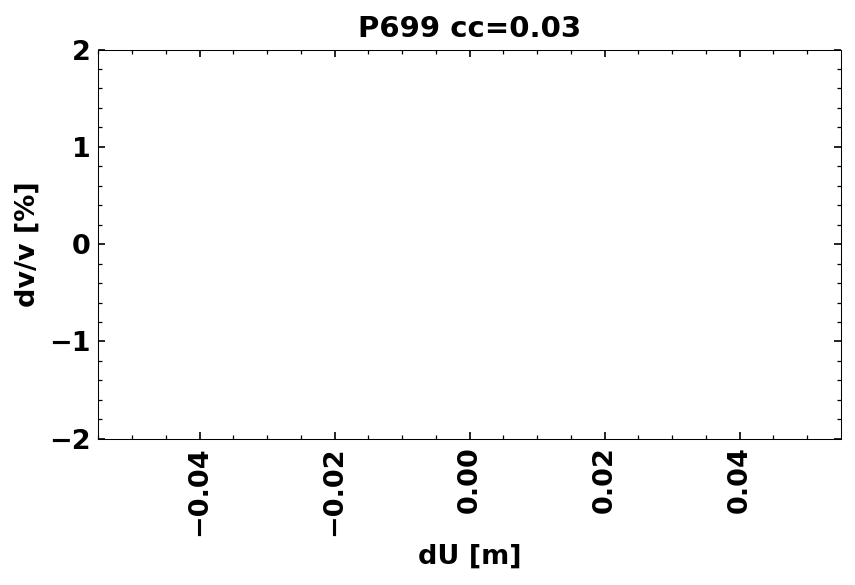

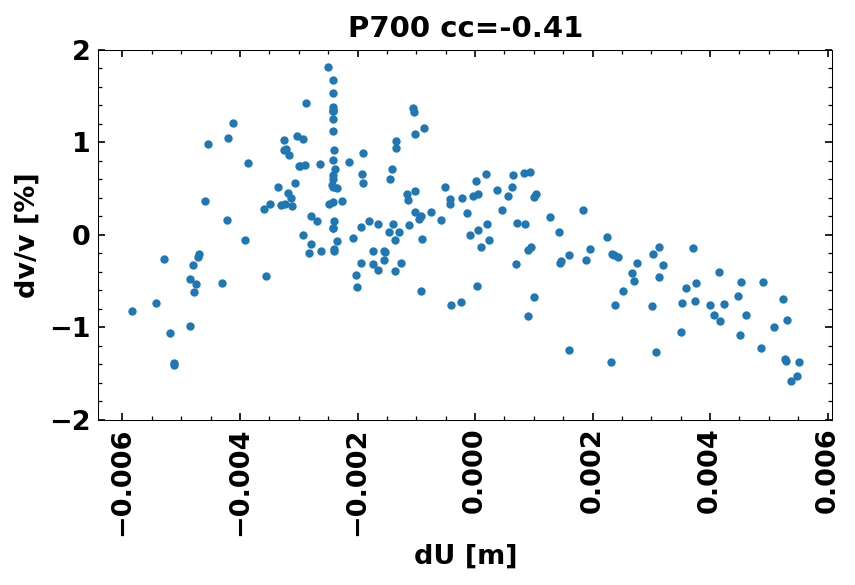

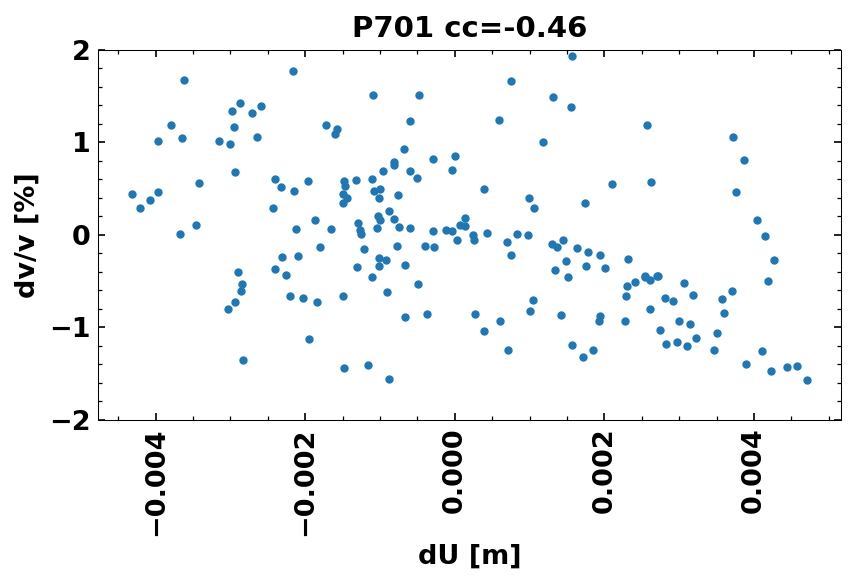

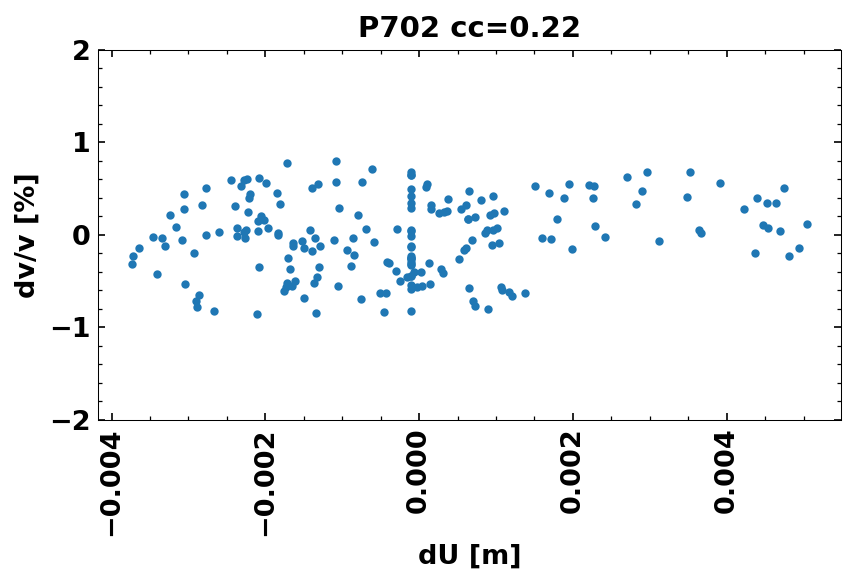

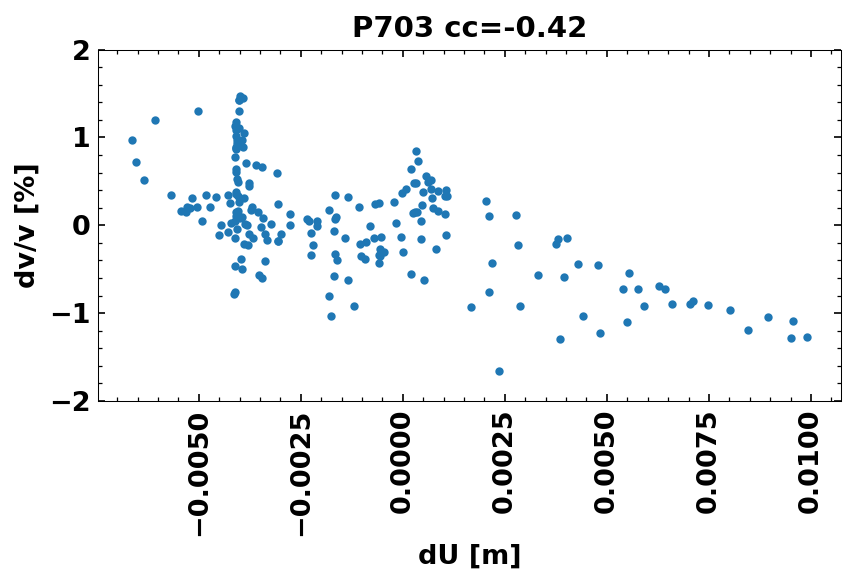

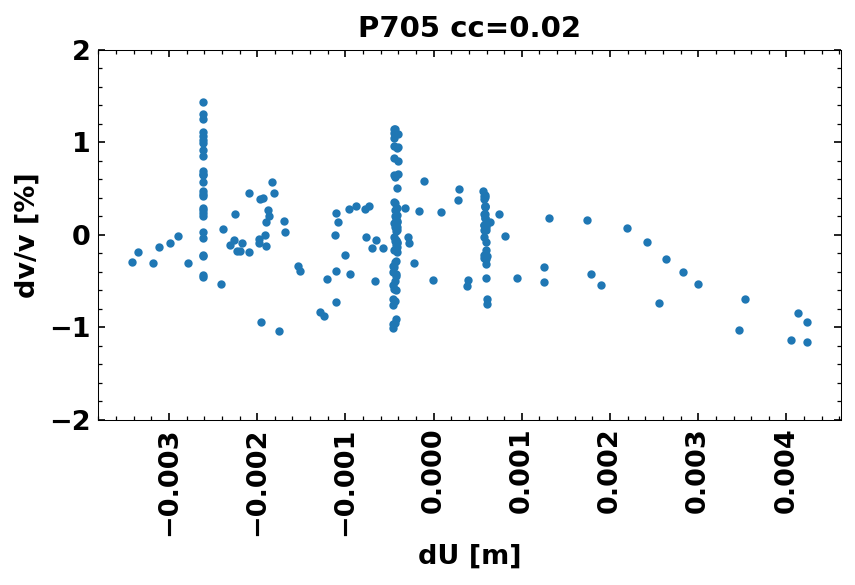

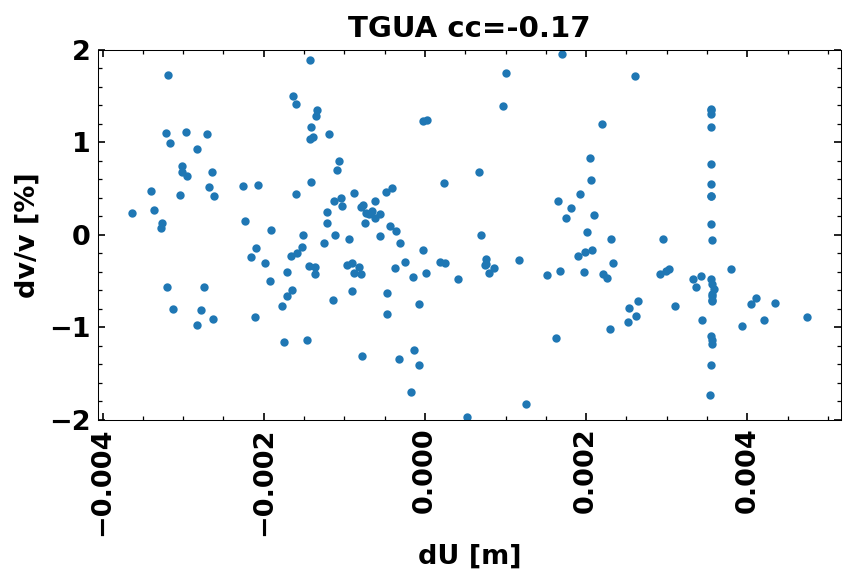

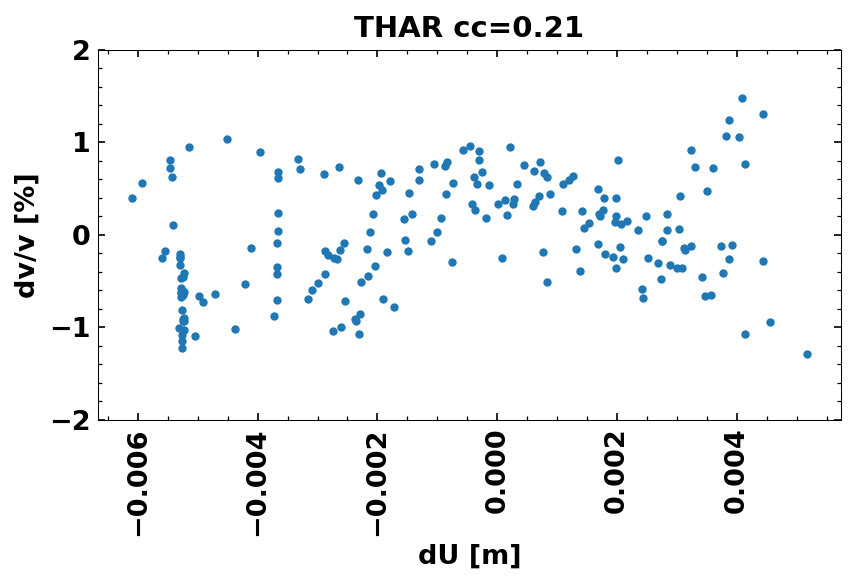

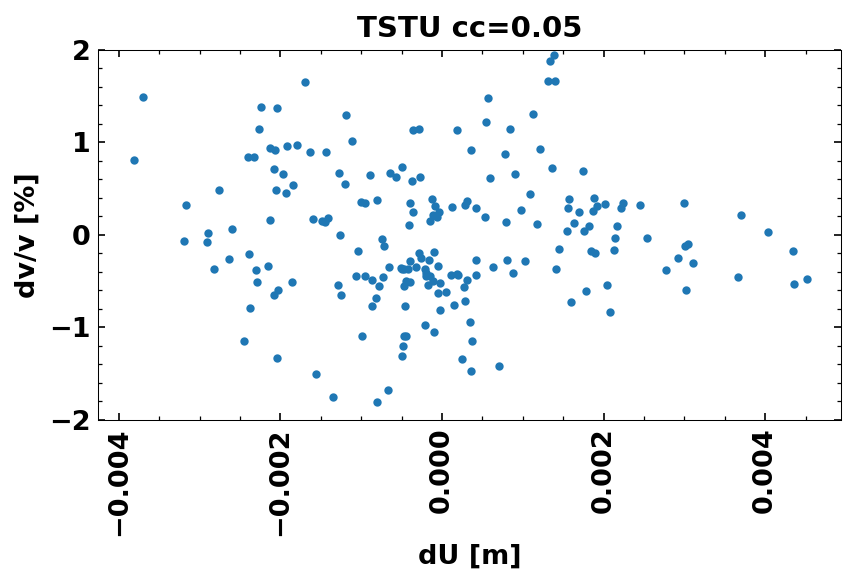

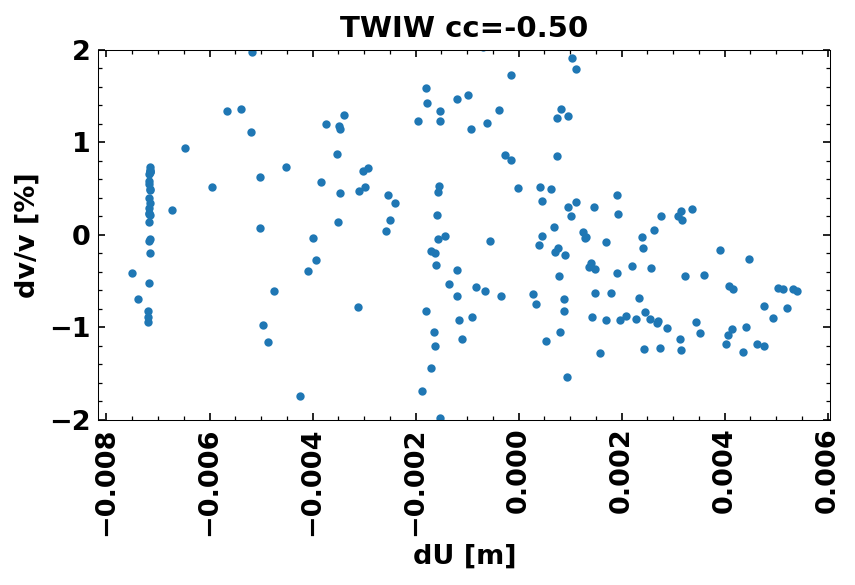

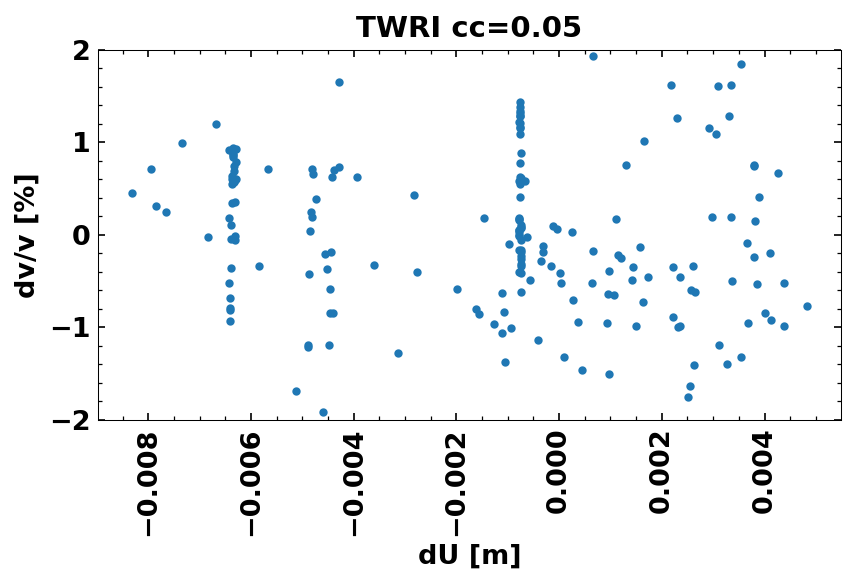

In [17]:
# do the same for the spatial data and make a plot for each GPS station as above
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# find closest grid point of each station and plot against dv/v of this grid point


# number of points to plot
npts = 200

for station, df in positions.items():
    gps_int = np.interp([UTCDateTime(_t).timestamp for _t in datetimes], [UTCDateTime(_t).timestamp for _t in df['datetime']], df['offset_hpf'], left=np.nan, right=np.nan)
    plt.figure()
    # find closest grid point
    # plt.plot(df['datetime'], df['offset_hpf'], label='GNSS', color='k')
    plt.xlabel('dU [m]')
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    xind = np.argmin(np.abs(df['x'][0] - x))
    yind = np.argmin(np.abs(df['y'][0] - y))
    # plot dv/v time series
    # for freq0 in [0.25, 0.5, 1.0]:
    #     # plt.plot(datetimes, dv_hpf[freq0][yind, xind, :], label=f'{freq0}-{freq0*2} Hz', linestyle='--')
    #     plt.plot(gps_int, dv_hpf[freq0][yind, xind, :], '.', label=f'{freq0}-{freq0*2} Hz')
    # compute average correlation coefficient between GPS and dv/v
    cc = np.dot(np.nan_to_num(gps_int), np.nan_to_num(dv_hpf[1.0][yind, xind]))
    df['cc'] = cc
    plt.plot(gps_int[-npts:], dv_hpf[1.0][yind, xind, -npts:], '.')#, label=f'{freq0}-{freq0*2} Hz')
    # plot this legend in top right
    # plt.legend(loc='upper right')
    plt.ylabel('dv/v [%]')
    plt.title(f'{station} cc={cc:.2f}')
    plt.ylim(-2, 2)
    
    plt.tight_layout()


### plot map with correlation coefficient between GPS and dv/v

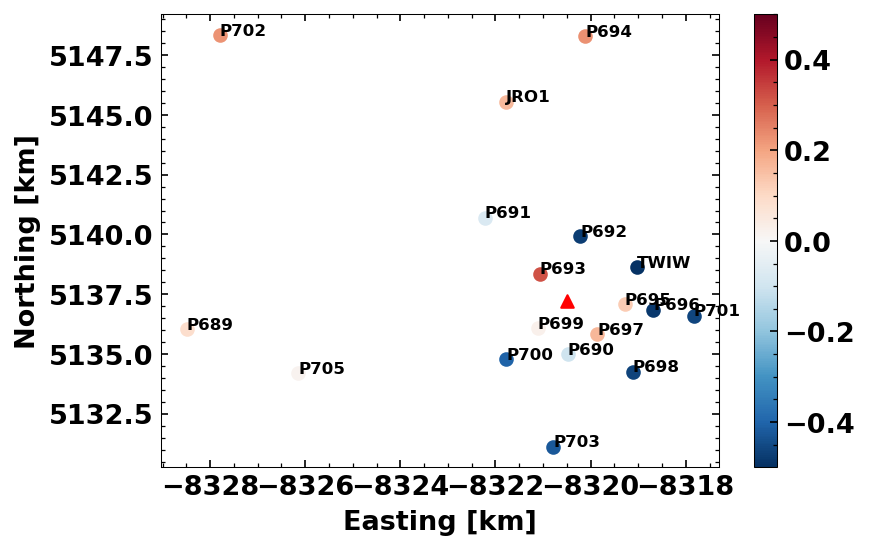

In [18]:
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    if np.isnan(df['offset'].values[-1]):
        continue
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['cc'][0], vmin=-0.5, vmax=0.5, cmap='RdBu_r')
    # plot the name of the station right next to the dot
    plt.text(df['x'].values[0], df['y'].values[0], station, fontsize=8)
# plot mount St Helens peak
plt.colorbar()
plt.ylabel('Northing [km]')
plt.xlabel('Easting [km]')
plt.scatter(-degrees2kilometers(locations2degrees(lat[0], 0, lat[0], -122.19)), degrees2kilometers(locations2degrees(0, lon[0], 46.20, lon[0])), marker='^', c='red')


In [ ]:
# same as above but using pygmt
# plot this together with the peak-to-peak seasonal amplitude of the dv/v time series (as a colormap)